# Genes consistently variable in healthy beta cells
- Find genes variable in all healthy beta cell samples individually. 
- Cluster them based on maximal distance across samples.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.patches import Patch

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist,squareform
from sklearn.preprocessing import minmax_scale,scale

from sklearn.linear_model import LinearRegression

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [2]:
ro.r('library("hypeR")')
ro.r("source(paste(Sys.getenv('WSCL'),'diabetes_analysis/data_exploration/','helper_hypeR.R',sep=''))")

R object with classes: ('list',) mapped to:
[SexpClosure, BoolSexpVector]
  value: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x7f1c2b4eca40> [RTYPES.CLOSXP]
  visible: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x7f1c2b4eda40> [RTYPES.LGLSXP]

In [3]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_save='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/moransi_healthy/sfintegrated/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [4]:
# load genes info for expression, rel beta expression, and citation info
genes_info=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/genePrioritisation_beta.tsv',index_col=0)

In [5]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [6]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

In [7]:
# Add full gene symbol info
adata_rn_b.var['gene_symbol']=h.get_symbols(adata_rn_b.var_names)
# Check that gene symbols not nan -
if (adata_rn_b.var.gene_symbol=='nan').sum() :
        raise ValueError('Some gene symbols are nan - requires different parsing')

## Variable genes 

### Prepare adata

Select healthy samples. 

Spikein drug is not used as it seems to differ from other healthy samples, potentially due to longer culturing of islets or other technical effects that could affect results.

In [8]:
# Healthy adult samples
samples=['STZ_G1_control','VSG_MUC13633_chow_WT','VSG_MUC13634_chow_WT',
         'Fltp_adult_mouse1_head_Fltp-','Fltp_adult_mouse2_head_Fltp+',
         'Fltp_adult_mouse4_tail_Fltp+','Fltp_adult_mouse3_tail_Fltp-']

In [9]:
adata_rn_b_sub=adata_rn_b[~adata_rn_b.obs['leiden_r1.5'].isin(['19','20']),:].copy()

All is done on per-sample embedding to remove potential integration effects.

In [10]:
# Make per sample adatas
adatas_sub={}
for sample in samples:
    print(sample)
    # Subset to cells from sample
    adata_temp=adata_rn_b_sub[adata_rn_b_sub.obs.study_sample_design==sample].copy()
    # Compute embedding on sample data
    # Remove lowly expressed genes
    adata_temp.var['n_cells']=np.asarray((adata_temp.X>0).sum(axis=0)).ravel()
    adata_temp=adata_temp[:,adata_temp.var['n_cells']>=20].copy()
    # HVG
    sc.pp.highly_variable_genes(adata_temp, flavor='cell_ranger', n_top_genes =2000)
    # Neighbors on scaled data
    adata_scl=adata_temp.copy()
    sc.pp.scale(adata_scl,max_value=10)
    n_pcs=15
    sc.pp.pca(adata_scl, n_comps=n_pcs, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata_scl,n_pcs = n_pcs) 
    sc.tl.umap(adata_scl)
    # Add neighbor info to unslcaed data
    adata_temp.obsp['connectivities']=adata_scl.obsp['connectivities']
    adata_temp.obsp['distances']=adata_scl.obsp['distances']
    adata_temp.uns['neighbors']=adata_scl.uns['neighbors']
    adata_temp.obsm['X_umap']=adata_scl.obsm['X_umap']
    
    # Clusters for clustering pseudobulk
    res=10
    cl_col='leiden_r'+str(res)
    sc.tl.leiden(adata_temp, resolution=res, key_added=cl_col, 
                 directed=True, use_weights=True)
    print('N clusters:',adata_temp.obs[cl_col].nunique())
    
    adatas_sub[sample]=adata_temp

STZ_G1_control
N clusters: 178
VSG_MUC13633_chow_WT
N clusters: 128
VSG_MUC13634_chow_WT
N clusters: 137
Fltp_adult_mouse1_head_Fltp-
N clusters: 128
Fltp_adult_mouse2_head_Fltp+
N clusters: 149
Fltp_adult_mouse4_tail_Fltp+
N clusters: 141
Fltp_adult_mouse3_tail_Fltp-
N clusters: 109


### Moran'sI
Moran's I on embedding of individual samples. Here we use per-sample and not integrated embedding to remove any variability that may be hidden by integration.

N_cells effect is regressed out of Moran's I scores, as explained in the GPs notebook.

We decided not to use HVGs as variable genes as: 1.) Variable genes are mostly lowly expressed noisy genes (with Moran's I highly expressed genes with clear patterns are prefered). 2.) It captures random variation and not variation that may be bio more relevant (if we trust that embedding captures biological variability).

STZ_G1_control
VSG_MUC13633_chow_WT
VSG_MUC13634_chow_WT
Fltp_adult_mouse1_head_Fltp-
Fltp_adult_mouse2_head_Fltp+
Fltp_adult_mouse4_tail_Fltp+
Fltp_adult_mouse3_tail_Fltp-


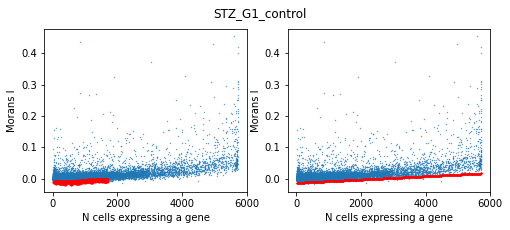

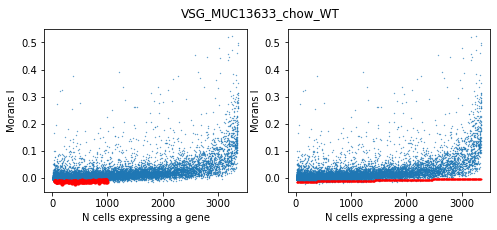

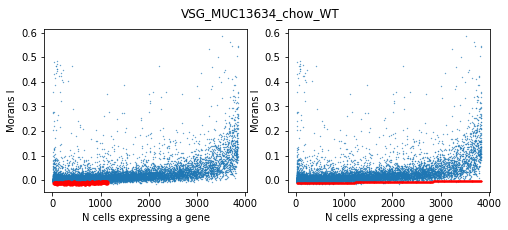

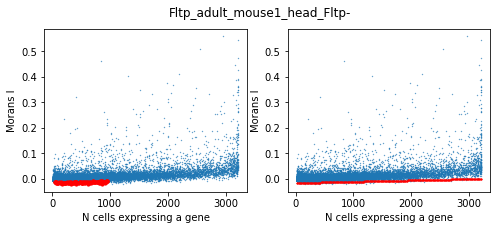

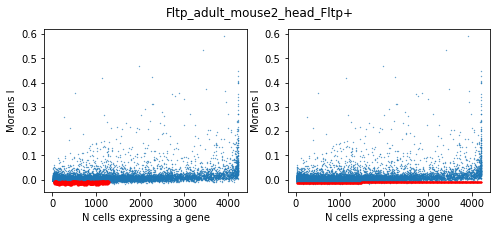

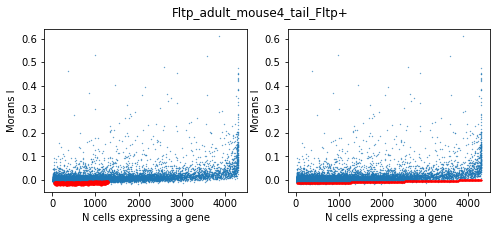

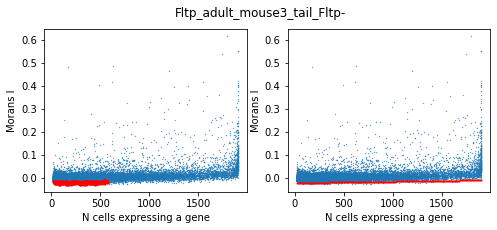

In [13]:
# Compute gene variability per sample
var_data={}
for sample in samples:
    print(sample)
    # Subset to cells from sample
    adata_temp=adatas_sub[sample].copy()
    
    # Compute morans i
    morans_i=sc.metrics.morans_i(adata_temp)
    morans_i=pd.DataFrame({'morans_i':morans_i},index=adata_temp.var_names)
    # N cells expressing gene
    morans_i['n_cells']=adata_temp.var['n_cells']
    
    # Regress out n cells effect from moran's I
    
    # Select base-level I genes for regression
    part=adata_temp.var['n_cells']<adata_temp.shape[0]*0.3
    bins=pd.cut(adata_temp.var['n_cells'][part],bins=20).to_frame()
    bins.columns=['bins']
    bins['morans_i']=morans_i[part]['morans_i']
    eids=bins.groupby('bins').apply(lambda x: x.loc[x.sort_values('morans_i').index[:5],:]).drop(
        'bins',axis=1).reset_index()['EID']
    
    # Plot all and selected Moran's instances
    fig,ax=plt.subplots(1,2,figsize=(8,3))
    fig.suptitle(sample)
    
    ax[0].scatter(adata_temp.var['n_cells'],morans_i['morans_i'],s=0.1)
    ax[0].set_xlabel('N cells expressing a gene')
    ax[0].set_ylabel('Morans I')
    ax[0].scatter(adata_temp.var.loc[eids,'n_cells'],morans_i.loc[eids,'morans_i'],s=10,c='r')
    
    # Base level regreession
    reg_base = LinearRegression().fit(adata_temp.var.loc[eids,'n_cells'].values.reshape(-1,1),
                             morans_i.loc[eids,'morans_i'].values.reshape(-1,1))
    
    # Plot regression
    ax[1].scatter(adata_temp.var['n_cells'],morans_i['morans_i'],s=0.1)
    ax[1].set_xlabel('N cells expressing a gene')
    ax[1].set_ylabel('Morans I')
    x_pred=range(adata_temp.var['n_cells'].min(),adata_temp.var['n_cells'].max(),10)
    ax[1].scatter(x_pred,reg_base.predict(np.array(x_pred).reshape(-1,1)).ravel(),c='r',s=1)
    
    # residuals compared to base-lvl I
    morans_i['morans_i_residual']=pd.Series((
            morans_i['morans_i'].values.reshape(-1,1)-reg_base.predict(
            adata_temp.var['n_cells'].values.reshape(-1,1))).ravel(),
        index=morans_i.index)
    
    var_data[sample]=morans_i
del adata_temp

In [18]:
# Save var data
pickle.dump(var_data,open(path_save+'varData.pkl','wb'))

In [10]:
# Select genes variable in each sample
thr=0.05
for sample,data in var_data.items():
    print(sample,'N genes at thr:',(data['morans_i_residual']>=thr).sum())

STZ_G1_control N genes at thr: 508
VSG_MUC13633_chow_WT N genes at thr: 1654
VSG_MUC13634_chow_WT N genes at thr: 1763
Fltp_adult_mouse1_head_Fltp- N genes at thr: 982
Fltp_adult_mouse2_head_Fltp+ N genes at thr: 782
Fltp_adult_mouse4_tail_Fltp+ N genes at thr: 863
Fltp_adult_mouse3_tail_Fltp- N genes at thr: 1142


In [94]:
# Genes variable in all samples
genes_all=set.intersection(
    *[set(var[var['morans_i_residual']>=thr].index) for var in var_data.values()])
print('N genes with high mnorns I in all datasets at that threshold:',len(genes_all))

N genes with high mnorns I in all datasets at that threshold: 265


## Cluster variable genes on adult healthy data
Cluster based on max distance between genes across samples.

Compute distances between genes on samples

In [14]:
# Subset to healthy adult data
adata_rn_b_sub_h=adata_rn_b_sub[adata_rn_b_sub.obs.study_sample_design.isin(samples),:].copy()

In [14]:
# Highest distance between genes within samples on per-sample pseudobulk
distances={}
cl_col='leiden_r10'
adata_genes=[]
for sample in samples:
    print(sample)
    # Subset to cells from sample
    adata_temp=adatas_sub[sample].copy()
    
    # Make df of genes vs mean expression across cell clusters 
    cell_cls=adata_temp.obs[cl_col].unique()
    features_temp=pd.DataFrame(index=genes_all,columns=cell_cls)
    for cell_cl in cell_cls:
        features_temp[cell_cl]=np.array(adata_temp[
            adata_temp.obs[cl_col]==cell_cl,features_temp.index].X.mean(axis=0)).ravel()
    adata_genes.append(sc.AnnData(features_temp,
                            var=pd.DataFrame({'sample':[sample]*features_temp.shape[1]},
                                            index=features_temp.columns)).T)
    
    # Compute distance    
    dist=pdist(features_temp,metric='correlation')
    distances[sample]=dist
    
del adata_temp
adata_genes=sc.AnnData.concatenate(*adata_genes).T

STZ_G1_control


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


VSG_MUC13633_chow_WT
VSG_MUC13634_chow_WT
Fltp_adult_mouse1_head_Fltp-
Fltp_adult_mouse2_head_Fltp+
Fltp_adult_mouse4_tail_Fltp+
Fltp_adult_mouse3_tail_Fltp-


Make sure that distance distn are comparable across samples - so that max across samples can be used

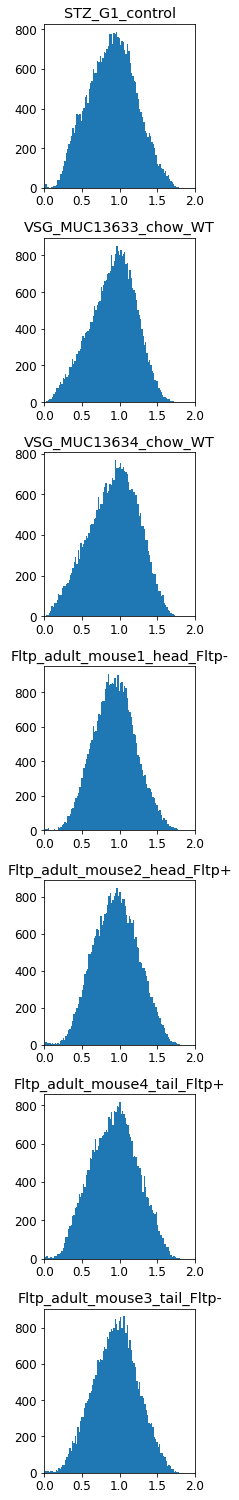

In [101]:
# Plot distance distns across samples
fig,ax=plt.subplots(len(distances),1,figsize=(3,3*len(distances)))
for idx,(s,d) in enumerate(distances.items()):
    ax[idx].hist(d,bins=100)
    ax[idx].set_xlim(0,2)
    ax[idx].set_title(s)
fig.tight_layout()

Cluster based on max distn across samples

In [15]:
# Compute summarised distances as max across samples
dist_max=np.array([dist for dist in distances.values()]).max(axis=0)

In [16]:
# Compute hc
hc=linkage(dist_max, method='ward',  optimal_ordering=True)

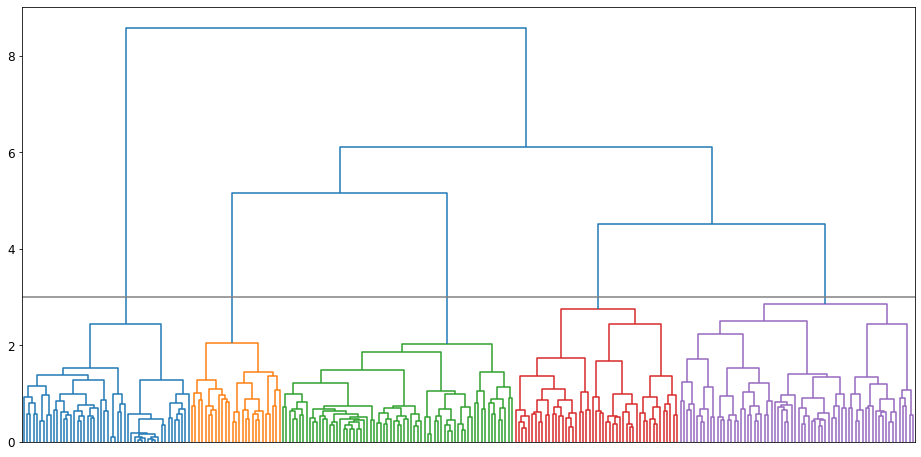

In [53]:
# Plot dendrogram
rcParams['figure.figsize']=(16,8)
adata_genes.uns['hc_colors']=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
                'tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan',
                'lightsteelblue','bisque','limegreen','lightcoral','plum',
                'peru','pink','darkgrey','yellowgreen','paleturquoise','yellow','black',
                'gold','brown','navy','forestgreen','lime','lightsalmon','teal','olive']
hierarchy.set_link_color_palette(adata_genes.uns['hc_colors'])
cut_thresh=3
dend=dendrogram(hc,color_threshold=cut_thresh,no_labels=True)
plt.axhline(cut_thresh,c='gray')

In [54]:
# Extract clusters at selected cutting threshold
adata_genes.obs['hc']=fcluster(hc,t=cut_thresh,criterion='distance')
# Sort categories to match colors
adata_genes.obs['hc']=pd.Categorical(adata_genes.obs['hc'], 
                      categories=sorted(adata_genes.obs['hc'].unique()),
                      ordered=True)

print('N gene clusters:',adata_genes.obs.hc.nunique())

N gene clusters: 5


In [29]:
# Colors for heatmap
adata_genes.uns['sample_colors']=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
                'tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan',
                'lightsteelblue','bisque','limegreen','lightcoral','plum',
                'peru','pink','darkgrey','yellowgreen','paleturquoise','yellow','black',
                'gold','brown','navy','forestgreen','lime','lightsalmon','teal','olive']
adata_genes.var['sample']=adata_genes.var['sample'].astype('category')

Gene clusters expression across samples

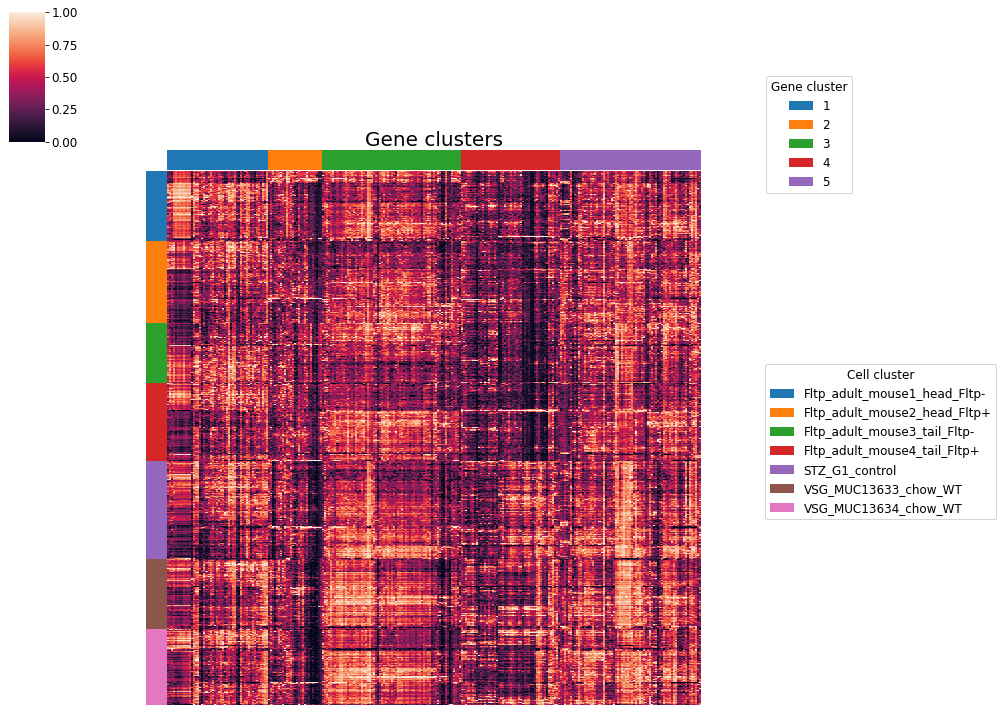

In [55]:
# Prepare some data for gene clusters heatmap
# Which clustering to show
gene_clustering='hc'
cell_clustering='sample'
# ordered genes by clusters
gene_list=[gene for cl in adata_genes.obs[gene_clustering].cat.categories
           for gene in adata_genes.obs_names[adata_genes.obs[gene_clustering]==cl]]

# Order genes by clustering from hc - also ordered by cluster
#gene_list=adata_genes.obs['hc_order'].sort_values().index
# ordered gene colors 
cl_list=[adata_genes.uns[gene_clustering+'_colors'][idx] for idx,cl in 
         enumerate(adata_genes.obs[gene_clustering].cat.categories)
         for gene in adata_genes.obs_names[adata_genes.obs[gene_clustering]==cl]]
cell_cl_list=[adata_genes.uns[cell_clustering+'_colors'][idx] for idx,cl in 
         enumerate(adata_genes.var[cell_clustering].cat.categories)
         for cell in adata_genes.var_names[adata_genes.var[cell_clustering]==cl]]
x_temp=pd.DataFrame( adata_genes.X.T,
                    index=adata_genes.var_names,columns=adata_genes.obs_names)[gene_list]
x_temp['sample']=adata_genes.var['sample']
x_temp=x_temp.groupby('sample').apply(lambda x: 
      pd.DataFrame(minmax_scale(x.drop('sample',axis=1)),
      index=x.index,columns=[c for c in x.columns if c!='sample']))
# Order within clusters
gene_list= h.opt_order_withincl(x_temp.T,adata_genes.obs[gene_clustering],
                               cl_order=adata_genes.obs[gene_clustering].cat.categories)
cell_list= h.opt_order_withincl(x_temp,adata_genes.var[cell_clustering],
                                cl_order=adata_genes.var[cell_clustering].cat.categories)

fg=sb.clustermap(x_temp.loc[cell_list,gene_list], 
              col_colors=cl_list, row_colors=cell_cl_list,
              col_cluster=False,row_cluster=False,
             xticklabels=False, yticklabels=False)
 # Adds block annotation titles as axis labels
fg.ax_col_colors.set_xlabel('Gene clusters',fontsize=20)
fg.ax_col_colors.xaxis.set_label_position('top') 
# legend for gene clusters
handles = [Patch(facecolor=c) for c in adata_genes.uns[gene_clustering+'_colors']]
l1=plt.legend(handles, adata_genes.obs[gene_clustering].cat.categories, title='Gene cluster',
           bbox_to_anchor=(1.2, 0.9), bbox_transform=plt.gcf().transFigure)
# legend for cell clusters
handles = [Patch(facecolor=c) for c in adata_genes.uns[cell_clustering+'_colors']]
l2=plt.legend(handles, adata_genes.var[cell_clustering].cat.categories, title='Cell cluster',
           bbox_to_anchor=(1.4, 0.5), bbox_transform=plt.gcf().transFigure)
plt.gca().add_artist(l1)

In [31]:
# Cluster sizes
adata_genes.obs['hc'].value_counts()

5    70
3    69
1    50
4    49
2    27
Name: cl, dtype: int64

Per-sample computed gene cluster scores plotted on embedding of each sample (unintegrated)

In [12]:
# gene cluster scores on healthy beta cells computed per sample
gene_cl='hc'
for adata_temp in adatas_sub.values():
    adata_temp.obs.drop([col for col in adata_temp.obs.columns 
                         if 'gene_score_cluster_'+gene_cl in col],axis=1,inplace=True)
    for ct in sorted(adata_genes.obs[gene_cl].unique()):
        score_name='gene_score_cluster_'+gene_cl+str(ct)
        sc.tl.score_genes(adata_temp, 
                          gene_list=adata_genes.obs_names[adata_genes.obs[gene_cl]==ct], 
                         score_name=score_name, use_raw=False)
del adata_temp

STZ_G1_control


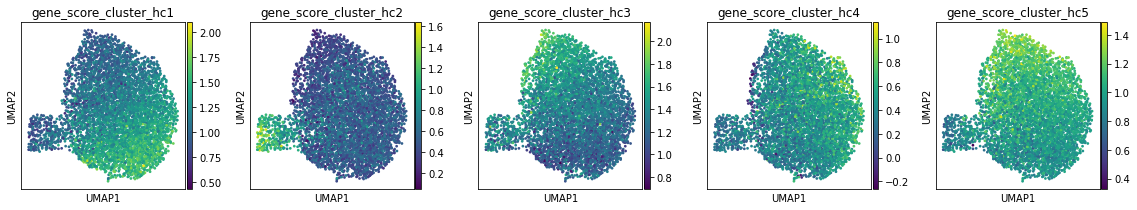

VSG_MUC13633_chow_WT


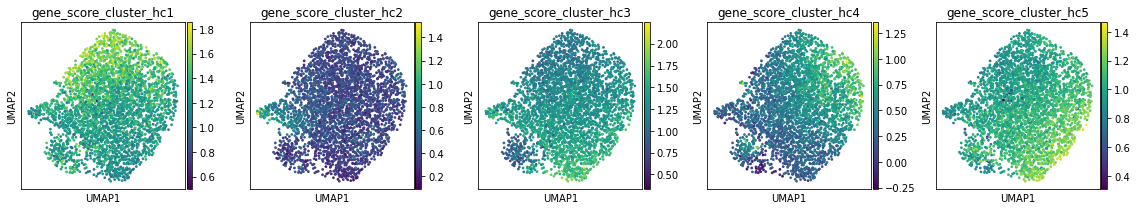

VSG_MUC13634_chow_WT


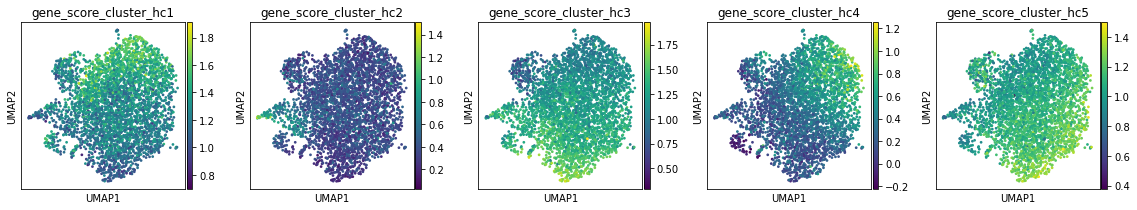

Fltp_adult_mouse1_head_Fltp-


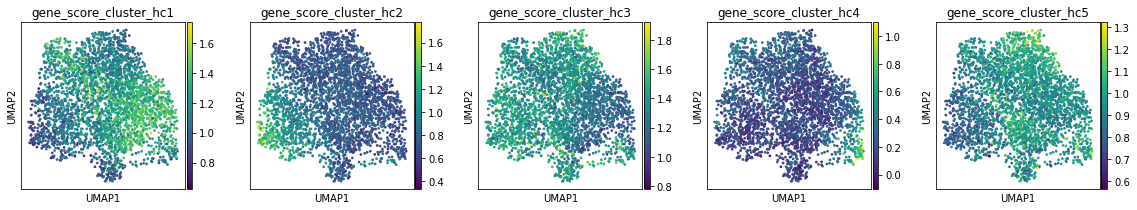

Fltp_adult_mouse2_head_Fltp+


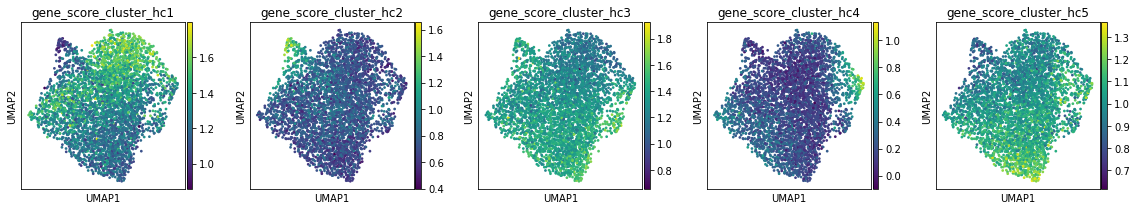

Fltp_adult_mouse4_tail_Fltp+


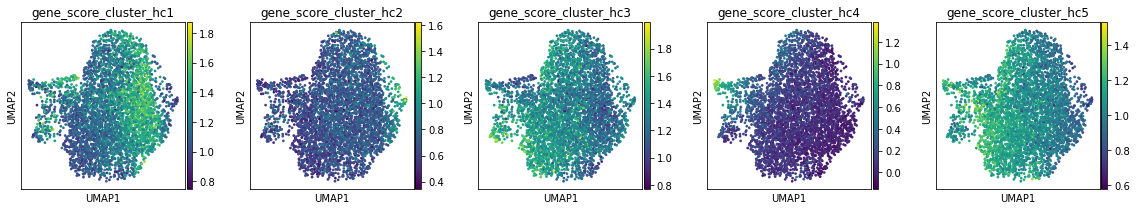

Fltp_adult_mouse3_tail_Fltp-


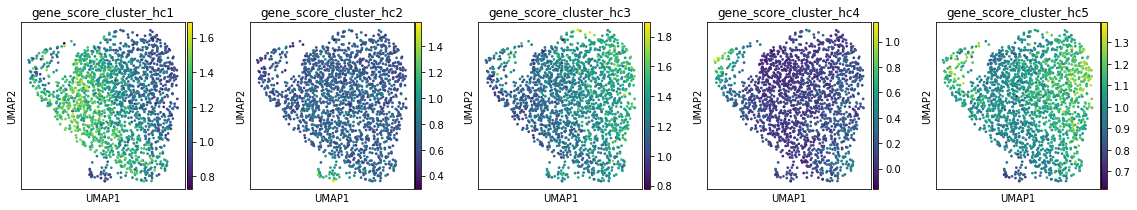

In [33]:
for sample,adata_temp in adatas_sub.items():
    rcParams['figure.figsize']=(3,3)
    print(sample)
    random_indices=np.random.permutation(list(range(adata_temp.shape[0])))
    sc.pl.umap(adata_temp[random_indices,:],color=[col for col in adata_temp.obs.columns 
        if 'gene_score_cluster_hc' in col and '_scaled'  not in col], s=30,sort_order=False,
               ncols=5)
del adata_temp

## Analyse gene clusters

### Gene group score sterength comparison across samples
Comparison of scores (computed across all samples) between samples. Are some samples in generally higher/lower for gene group?

In [15]:
# gene cluster scores on healthy beta cells computed altogether
gene_cl='hc'
adata_rn_b_sub_h.obs.drop([col for col in adata_rn_b_sub_h.obs.columns 
                     if 'gene_score_cluster_'+gene_cl in col],axis=1,inplace=True)
for ct in sorted(adata_genes.obs[gene_cl].unique()):
    score_name='gene_score_cluster_'+gene_cl+str(ct)
    sc.tl.score_genes(adata_rn_b_sub_h, 
                      gene_list=adata_genes.obs_names[adata_genes.obs[gene_cl]==ct], 
                     score_name=score_name, use_raw=False)
    adata_rn_b_sub_h.obs[score_name+'_scaled']=minmax_scale(adata_rn_b_sub_h.obs[score_name])

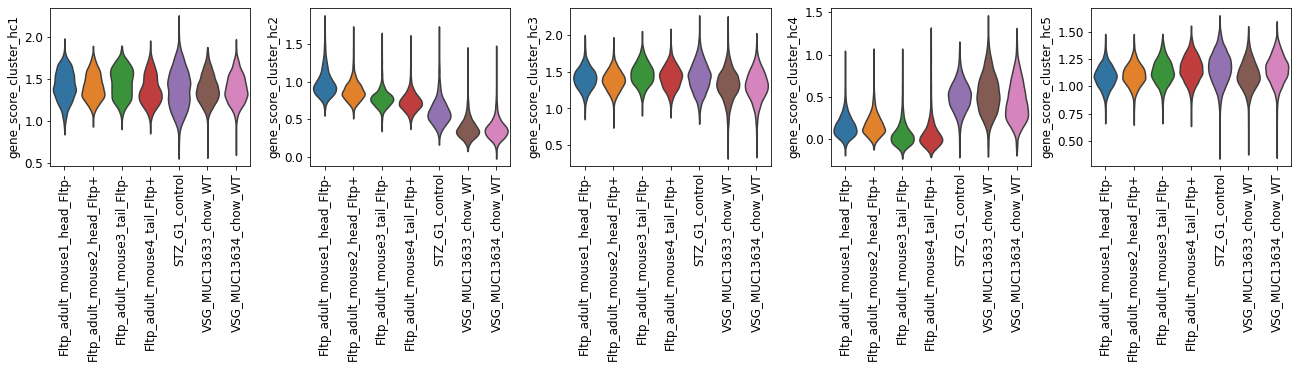

In [62]:
# Distn of gene scores across samples
rcParams['figure.figsize']=(4,3)
sc.pl.violin(adata_rn_b_sub_h, keys=[col for col in adata_rn_b_sub_h.obs.columns 
    if 'gene_score_cluster_hc' in col and '_scaled' not  in col], 
              groupby='study_sample_design', stripplot=False, 
               rotation=90)

<ipython-input-28-af11bcf111f8>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


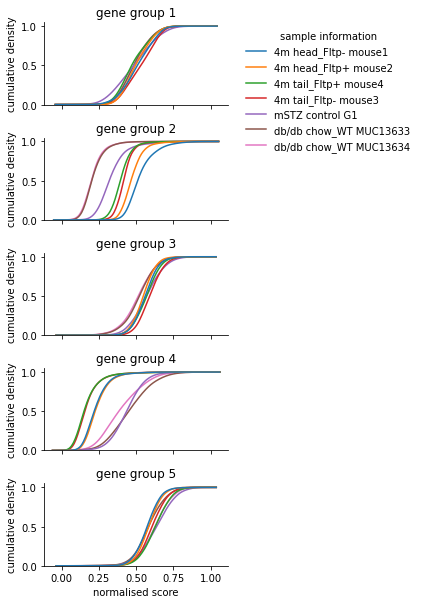

In [28]:
# KDE plots of individual scores scaled to [0,1]
def move_legend(ax, bbox_to_anchor, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), title=title, **kws)

# Parsed sample info
adata_rn_b_sub_h.obs['studyparsed_design_sample']=[
    ' '.join(i) for i in 
     zip(adata_rn_b_sub_h.obs.study_parsed,adata_rn_b_sub_h.obs.design,adata_rn_b_sub_h.obs.file)]
adata_rn_b_sub_h.obs['studyparsed_design_sample']=pd.Categorical(
    values=adata_rn_b_sub_h.obs['studyparsed_design_sample'],ordered=True,
    categories=adata_rn_b_sub_h.obs[
        ['study_parsed','studyparsed_design_sample']].drop_duplicates().sort_values('study_parsed')[
        'studyparsed_design_sample'].values)
score_cols=['gene_score_cluster_hc'+str(col) for col in sorted(adata_genes.obs['hc'].unique())]
fig,axs=plt.subplots(len(score_cols),1,figsize=(3.3,2*len(score_cols)),
                    sharey=True,sharex=True)
for idx,score in enumerate(score_cols):
    ax=axs[idx]
    data=adata_rn_b_sub_h.obs.copy()
    data['study']
    data[score+'_scaled']=minmax_scale(data[score])
    sb.kdeplot(
        data=data, x=score+'_scaled', hue="studyparsed_design_sample",
        cumulative=True, common_norm=False, common_grid=True,ax=ax)
    # Transparent
    ax.set(facecolor = (0,0,0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Annotate
    ax.set_title('gene group '+score.replace('gene_score_cluster_hc',''))
    #ax.xaxis.set_label_position('top') 
    ax.set_ylabel('cumulative density')
    move_legend(ax=ax,bbox_to_anchor=(1.05, 1),)
    # remove legend from non-first plots
    if idx!=0:
        ax.get_legend().remove()
    # Transparent legend and change title
    else:
        ax.get_legend().get_frame().set_alpha(None)
        ax.get_legend().get_frame().set_facecolor((0, 0, 0, 0))
        ax.get_legend().get_frame().set_edgecolor((0, 0, 0, 0))
        ax.get_legend().set_title('sample information')
    if idx==len(score_cols)-1:
        ax.set_xlabel('normalised score')
plt.subplots_adjust(wspace=0, hspace=0.4)
fig.tight_layout()
plt.savefig(path_fig+'density_beta_healthyvar_sample.png',dpi=300,bbox_inches='tight')

C: Score 2 is more present in younger adults and score 4 is more present in older adults. Other scores have more similar distn over studies and samples.

### Function interpretation

#### Look at genes
Sort genes within gene groups by Moran's I across samples (using min to sumarise morans I across samples). Show most variable genes (Highest Moran's I across samples).

In [36]:
# For each cl report genes with largest min variability across samples
# Top genes with Moran's I
for cl,dat in adata_genes.obs.groupby('hc'):
    var_cl=pd.DataFrame(pd.concat([var.loc[dat.index,'morans_i'] 
                                   for var in var_data.values()],axis=1
                                 ).min(axis=1).sort_values(ascending=False))
    var_cl['gene_symbol']=adata_rn_b.var.loc[var_cl.index,'gene_symbol']
    print(cl)
    display(var_cl.head(10))

1


0 gene_symbol
ENSMUSG00000050708  0.309975        Ftl1
ENSMUSG00000031765  0.271286         Mt1
ENSMUSG00000064354  0.267542      mt-Co2
ENSMUSG00000031762  0.263761         Mt2
ENSMUSG00000064357  0.259748     mt-Atp6
ENSMUSG00000064363  0.250786      mt-Nd4
ENSMUSG00000064351  0.235777      mt-Co1
ENSMUSG00000064345  0.224115      mt-Nd2
ENSMUSG00000064358  0.214274      mt-Co3
ENSMUSG00000064370  0.208580     mt-Cytb

2


0 gene_symbol
ENSMUSG00000021194  0.198748        Chga
ENSMUSG00000017311  0.139271         Pyy
ENSMUSG00000057092  0.110921       Fxyd3
ENSMUSG00000037706  0.105730        Cd81
ENSMUSG00000021268  0.097133        Meg3
ENSMUSG00000092341  0.095077      Malat1
ENSMUSG00000066705  0.091529       Fxyd6
ENSMUSG00000047501  0.089284       Cldn4
ENSMUSG00000018339  0.085426        Gpx3
ENSMUSG00000059824  0.075387         Dbp

3


0 gene_symbol
ENSMUSG00000035804  0.419050        Ins1
ENSMUSG00000037852  0.226497         Cpe
ENSMUSG00000000215  0.208059        Ins2
ENSMUSG00000026864  0.169951       Hspa5
ENSMUSG00000041681  0.159801        Iapp
ENSMUSG00000022769  0.155645      Sdf2l1
ENSMUSG00000061808  0.153096         Ttr
ENSMUSG00000027350  0.148003        Chgb
ENSMUSG00000032575  0.144238        Manf
ENSMUSG00000015401  0.139989       Cltrn

4


0 gene_symbol
ENSMUSG00000052837  0.239449        Junb
ENSMUSG00000021025  0.235194      Nfkbia
ENSMUSG00000021250  0.234334         Fos
ENSMUSG00000071637  0.212314       Cebpd
ENSMUSG00000003545  0.183589        Fosb
ENSMUSG00000026628  0.183099        Atf3
ENSMUSG00000052684  0.179728         Jun
ENSMUSG00000038418  0.153774        Egr1
ENSMUSG00000091956  0.148182      C2cd4b
ENSMUSG00000091971  0.141620      Hspa1a

5


0 gene_symbol
ENSMUSG00000030785  0.271603      Cox6a2
ENSMUSG00000019505  0.215532         Ubb
ENSMUSG00000044139  0.186687      Prss53
ENSMUSG00000023034  0.152918       Nr4a1
ENSMUSG00000013593  0.148595      Ndufs2
ENSMUSG00000032265  0.145389      Tent5a
ENSMUSG00000057069  0.134428       Ero1b
ENSMUSG00000047591  0.127098        Mafa
ENSMUSG00000071076  0.121254        Jund
ENSMUSG00000029580  0.113600        Actb

In [56]:
# For each cl report genes ordered by largest min variability across samples
# Ordering of all genes
for cl,dat in adata_genes.obs.groupby('hc'):
    var_cl=pd.DataFrame(pd.concat([var.loc[dat.index,'morans_i'] 
                                   for var in var_data.values()],axis=1
                                 ).min(axis=1).sort_values(ascending=False))
    var_cl['gene_symbol']=adata_rn_b.var.loc[var_cl.index,'gene_symbol']
    print(cl)
    print(var_cl.gene_symbol.to_list())

1
['Ftl1', 'Mt1', 'mt-Co2', 'Mt2', 'mt-Atp6', 'mt-Nd4', 'mt-Co1', 'mt-Nd2', 'mt-Co3', 'mt-Cytb', 'Zdhhc2', 'mt-Nd5', 'Camk2n1', 'mt-Nd1', 'B2m', 'Cd63', 'mt-Nd3', 'Spc25', 'Pcp4', 'Ppp1r1a', 'Atp2a2', 'T2', 'Ucn3', 'Scg2', 'Neat1', 'Defb1', 'Nupr1', 'Chchd10', 'Th', 'Selenow', 'mt-Nd4l', 'Fdps', 'Cib3', 'Dnajc24', 'Gatm', 'Rnase4', 'Ttc28', 'Gad1', 'Glul', 'Ang', 'Atf5', 'Emid1', 'App', 'Ppargc1a', 'Lmo1', 'mt-Atp8', 'Uap1l1', 'Acot13', 'Dlgap1', 'Gapdh']
2
['Chga', 'Pyy', 'Fxyd3', 'Cd81', 'Meg3', 'Malat1', 'Fxyd6', 'Cldn4', 'Gpx3', 'Dbp', 'Ppy', 'Cldn3', 'H2bu2', 'Igfbp7', 'Tmsb15b2', 'Cd79a', 'Shisal2b', 'Sez6l', 'Baiap2', 'Sult1d1', 'Sdc4', 'Ramp1', 'Id2', 'Wnt4', 'Tspan8', 'Prss23', 'Plaat3']
3
['Ins1', 'Cpe', 'Ins2', 'Hspa5', 'Iapp', 'Sdf2l1', 'Ttr', 'Chgb', 'Manf', 'Cltrn', 'Ssr4', 'Pdyn', 'Pdia6', 'Cst3', 'Tm4sf4', 'Fkbp11', 'Dapl1', 'Pcsk2', 'Nucb2', 'Pappa2', 'Dnajb9', 'Snhg18', 'Itm2b', 'Ssr2', 'Itm2c', 'Tmed3', 'Calr', 'Pcsk1n', 'Scg5', 'Spcs1', 'Selenok', 'Tmem59', 'Spcs2',

#### Enrichment

In [21]:
# Ref genes - present in all var
ref=set.intersection(*[set(var.index) for var in var_data.values()])
ref=adata_rn_b.var.loc[ref,'gene_symbol'].to_list()
ro.globalenv['ref']=ref

GO+KEGG+REactome

In [22]:
# Get gene sets
print('MSIGdb version:',ro.r(f'msigdb_version()'))
gene_sets_go=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C5',subcategories=c('GO:BP','GO:CC','GO:MF'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
gene_sets_kegg=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('KEGG'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
gene_sets_reactome=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('REACTOME'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
%R -i gene_sets_go -i gene_sets_kegg -i gene_sets_reactome -o gene_sets gene_sets=c(gene_sets_go,gene_sets_kegg,gene_sets_reactome)
print('N gene sets:',len(gene_sets))
ro.globalenv['gene_sets']=gene_sets

MSIGdb version: ['v7.4.1']
N gene sets: 9410


CL 1
N genes 50
N enriched gene sets: 184
Top enriched gene sets


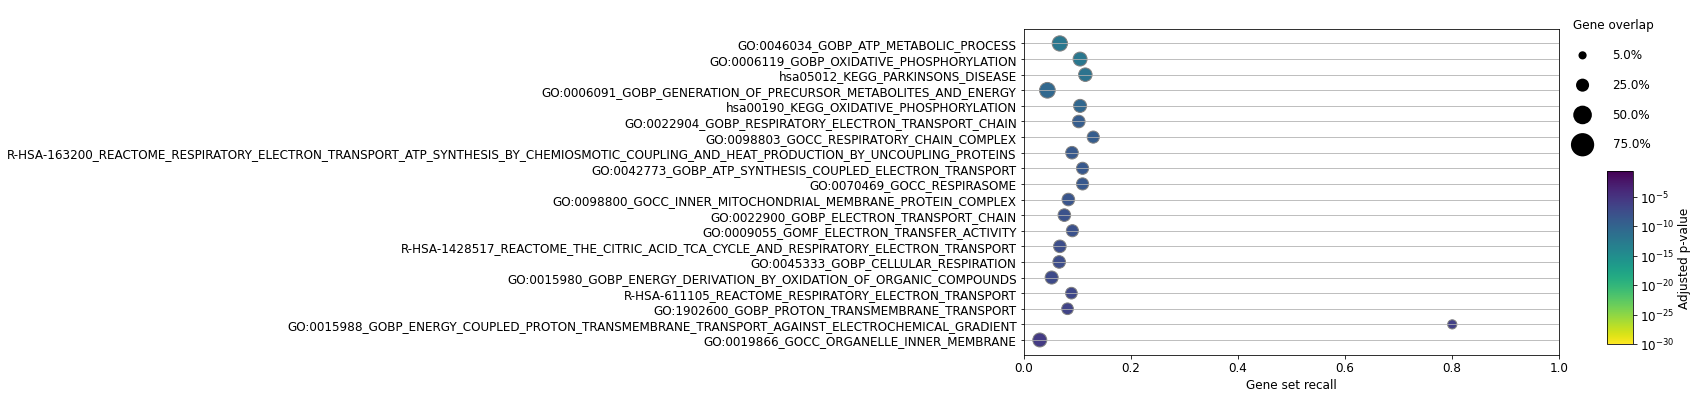

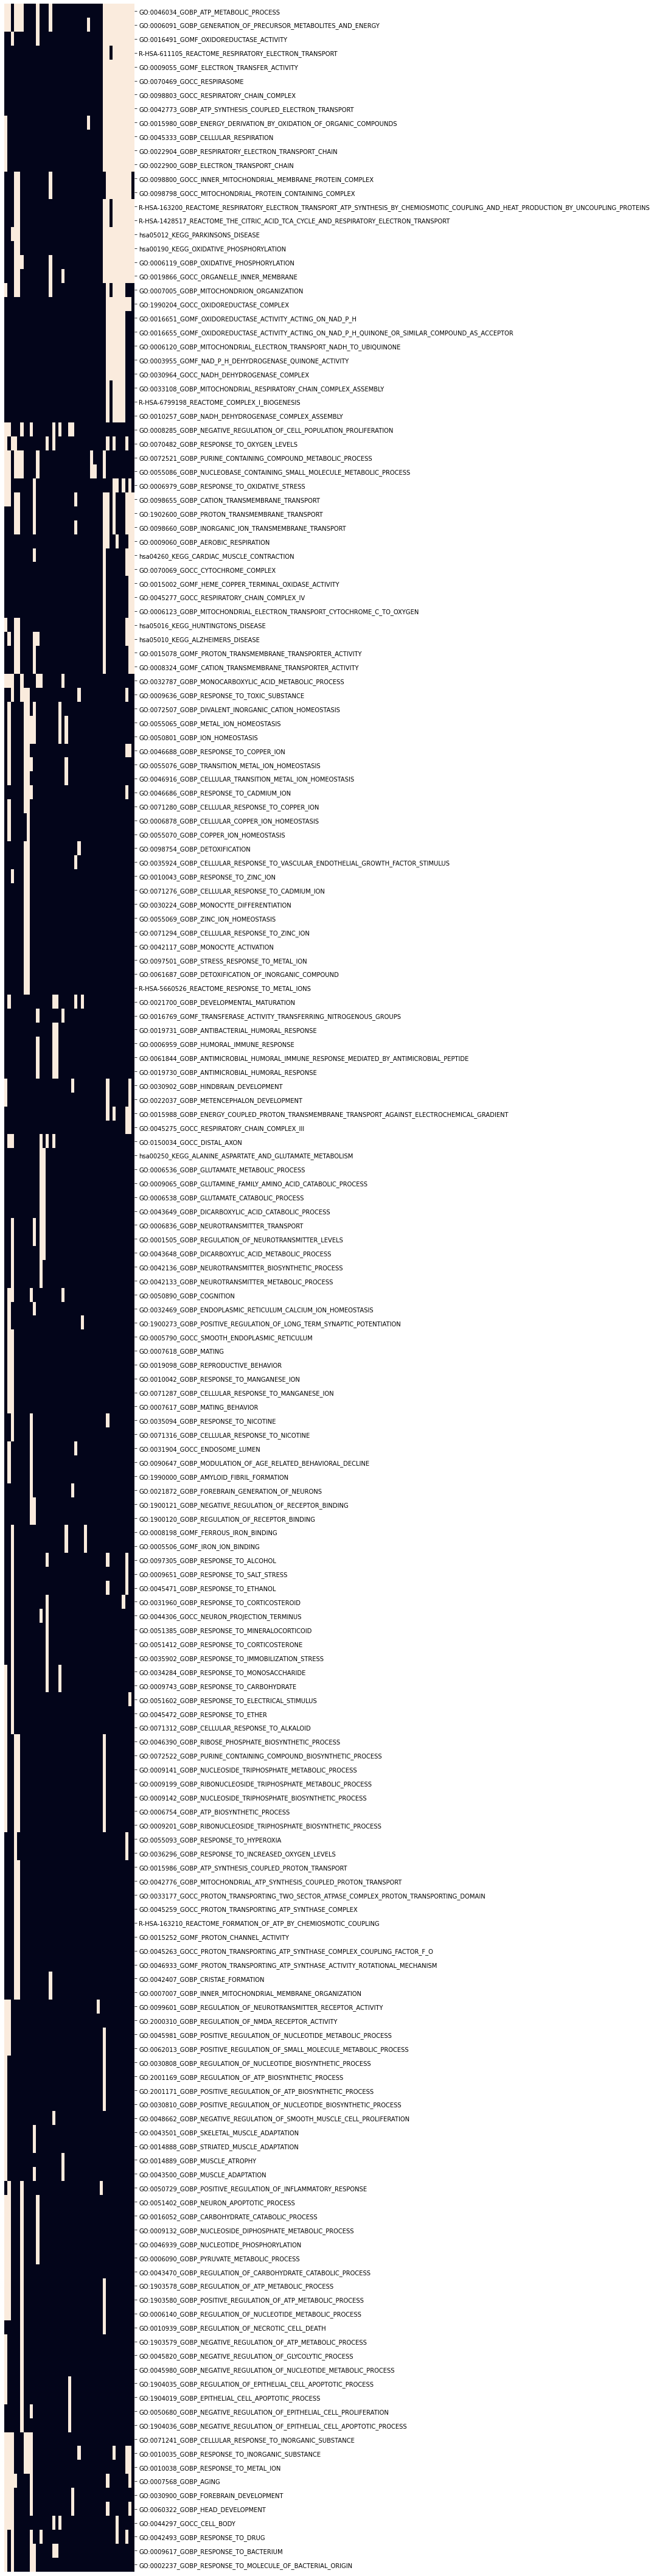

CL 2
N genes 27
N enriched gene sets: 15
Top enriched gene sets


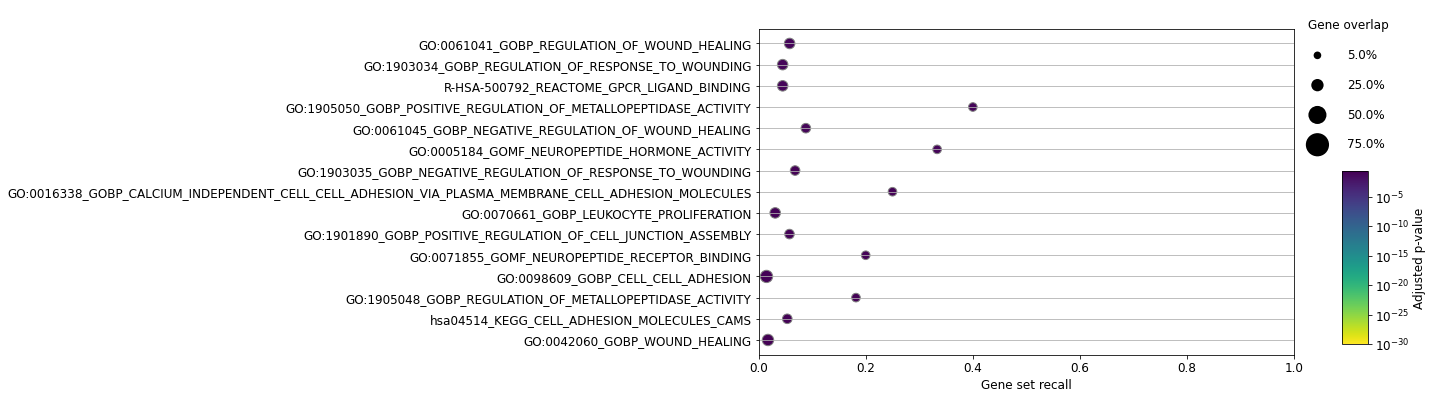

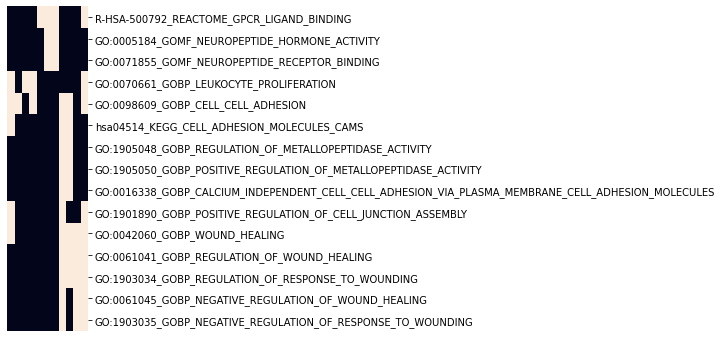

CL 3
N genes 69
N enriched gene sets: 115
Top enriched gene sets


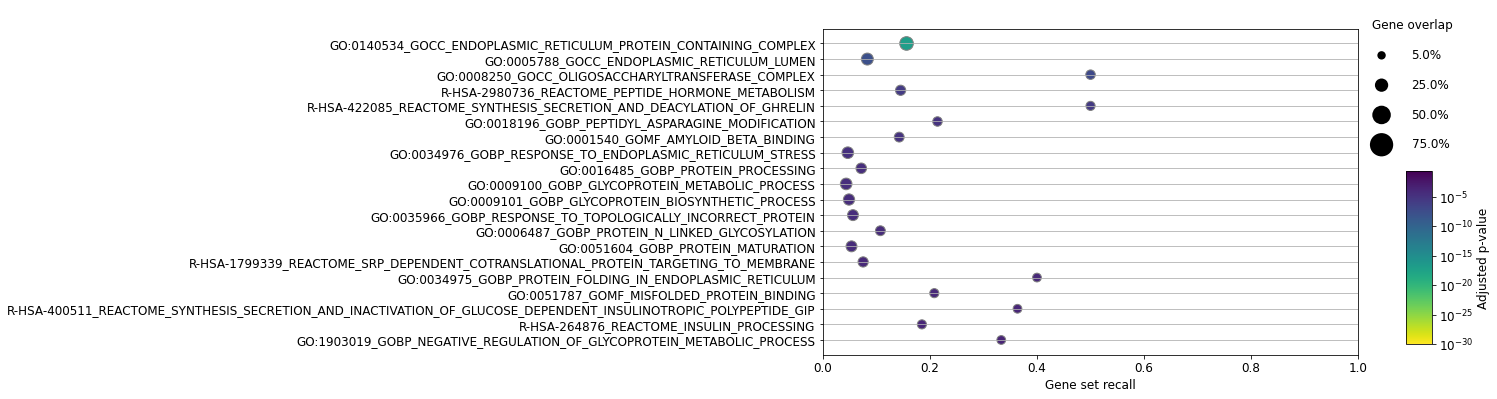

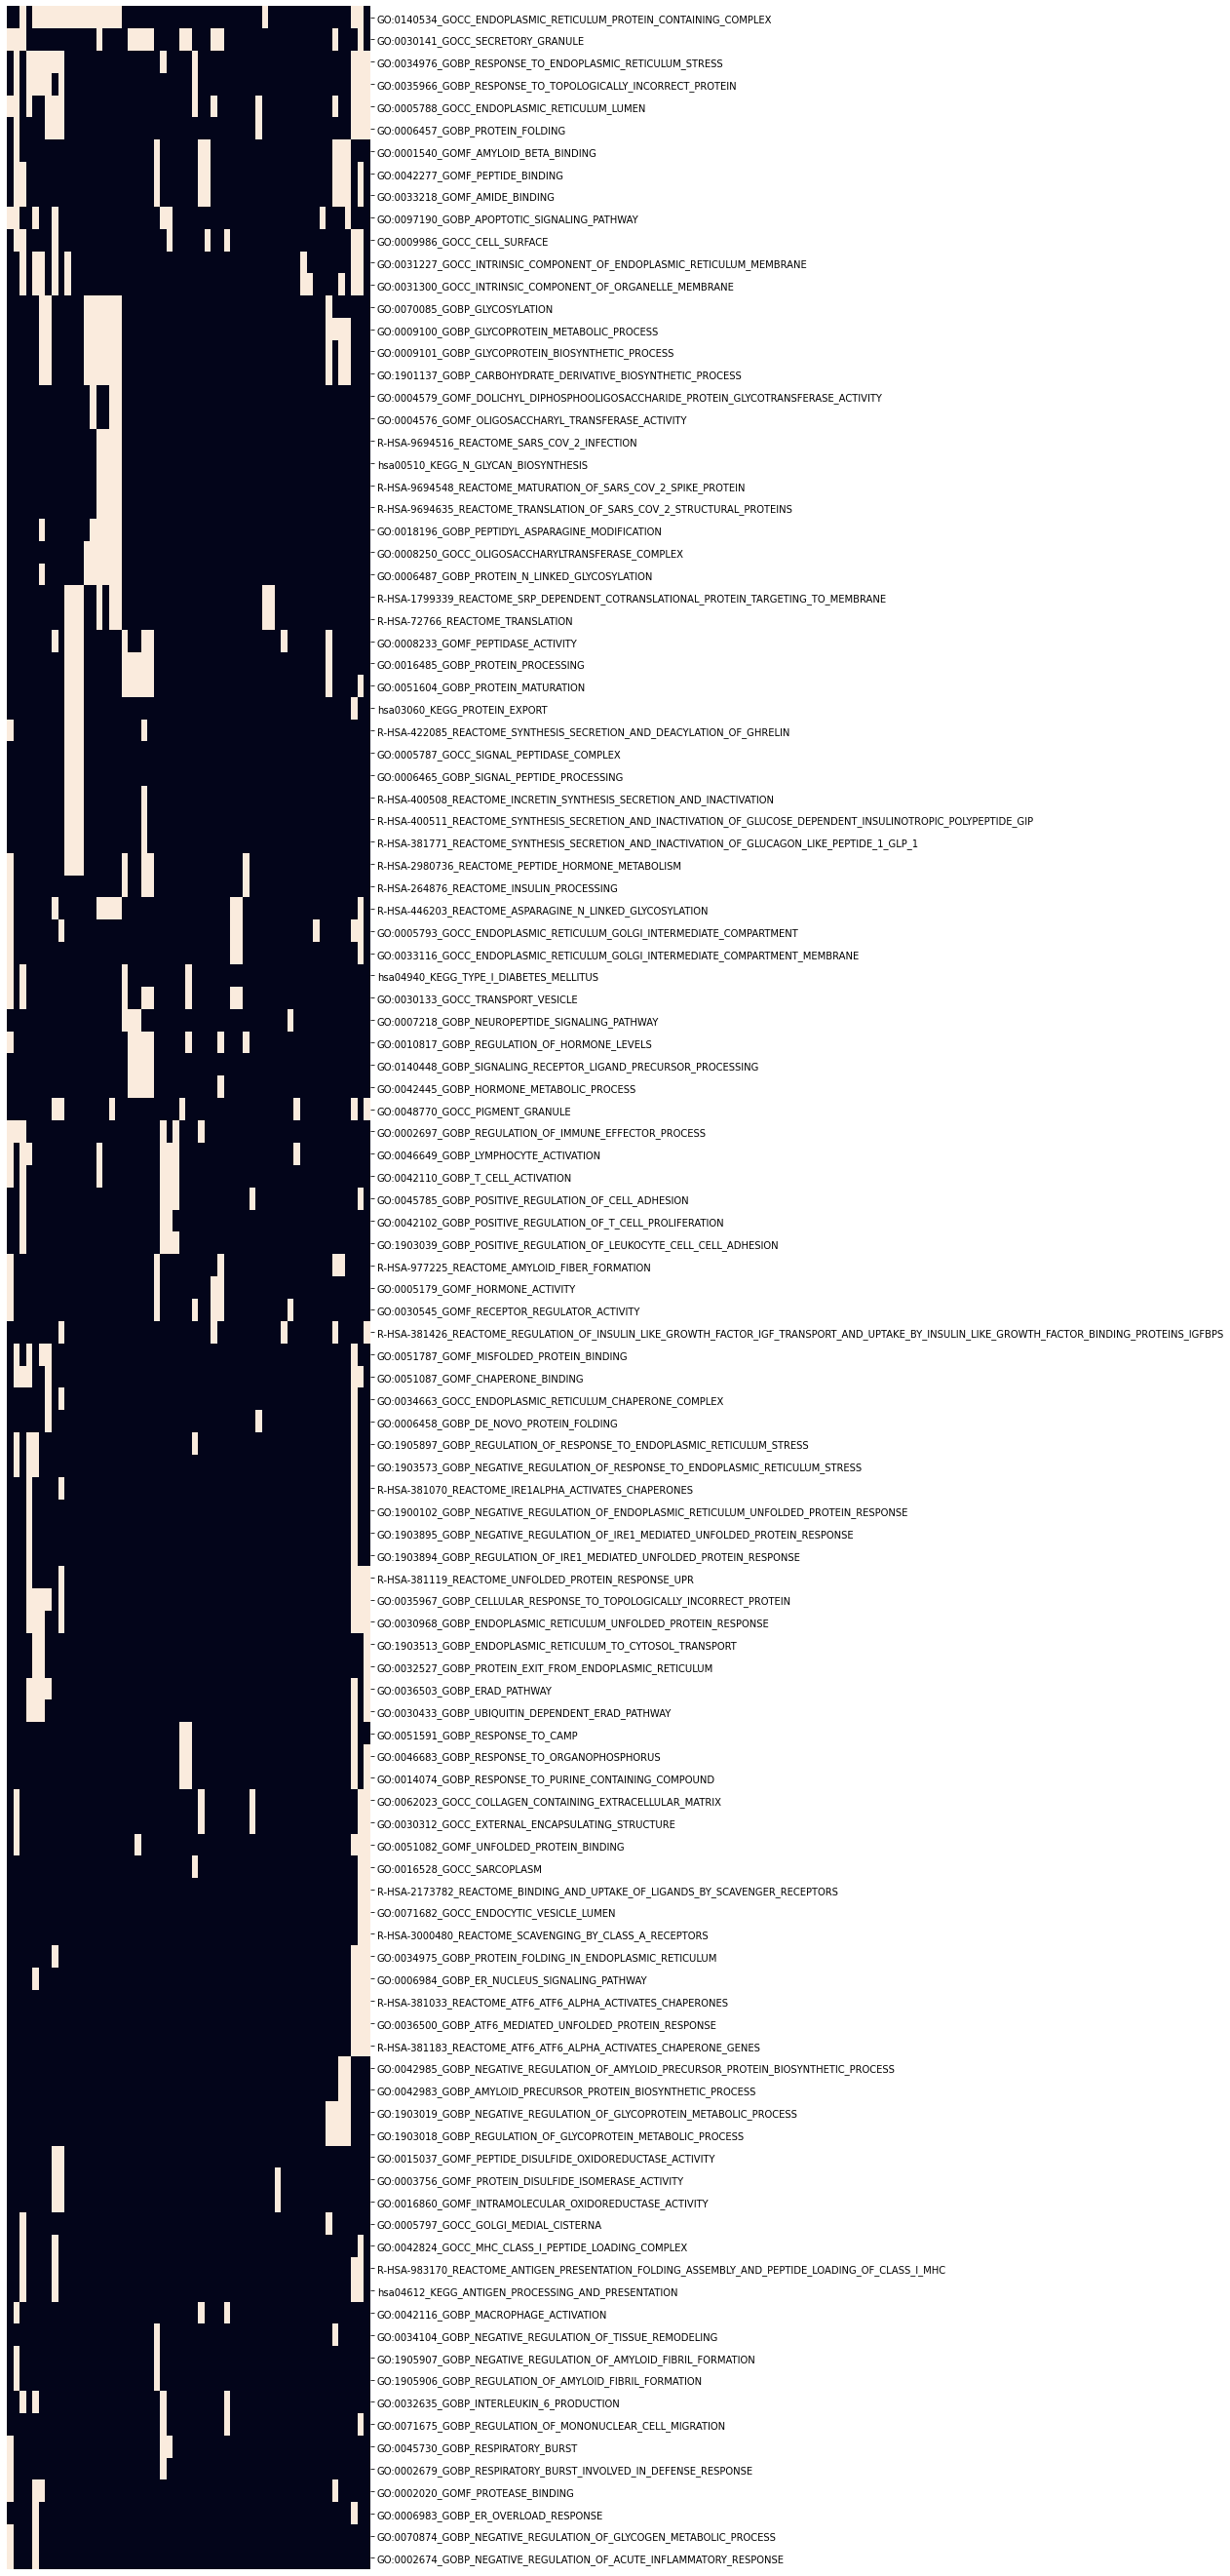

CL 4
N genes 49
N enriched gene sets: 356
Top enriched gene sets


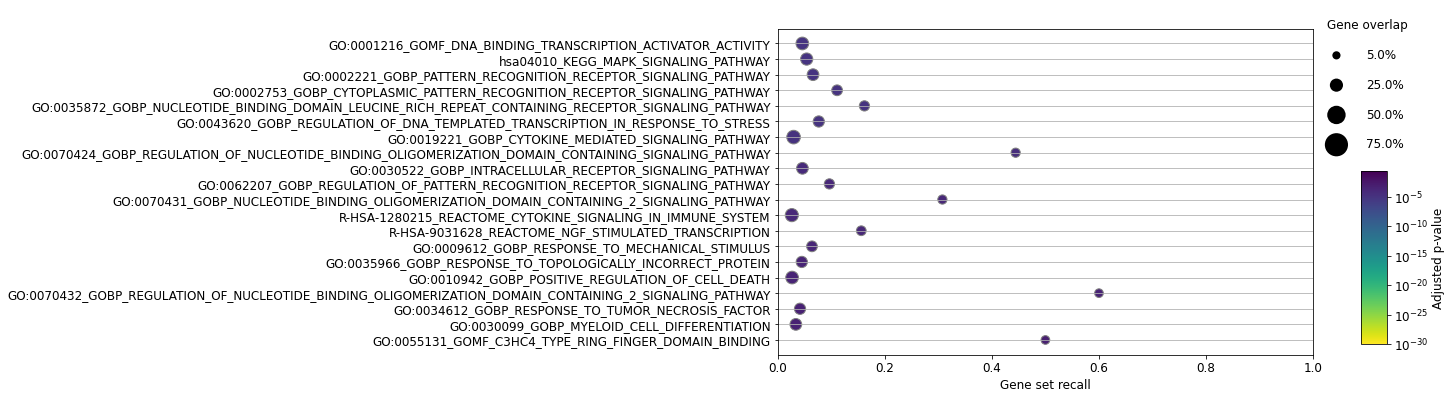

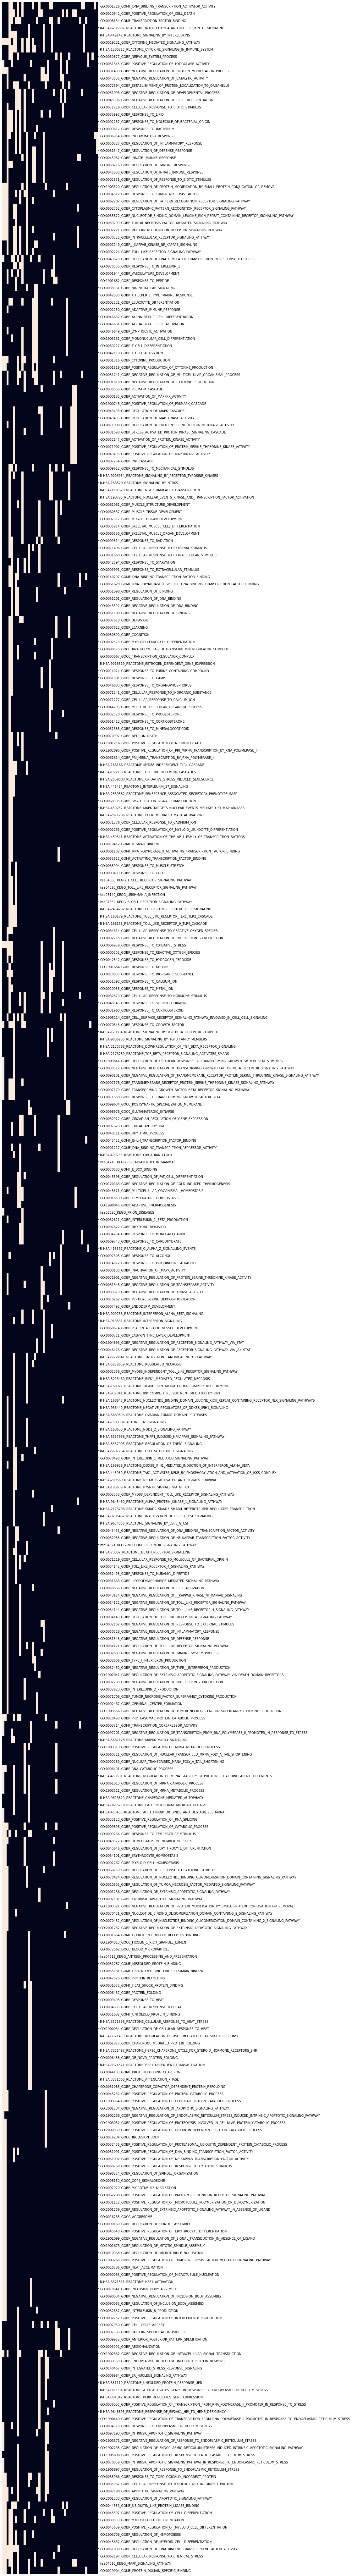

CL 5
N genes 70
N enriched gene sets: 299
Top enriched gene sets


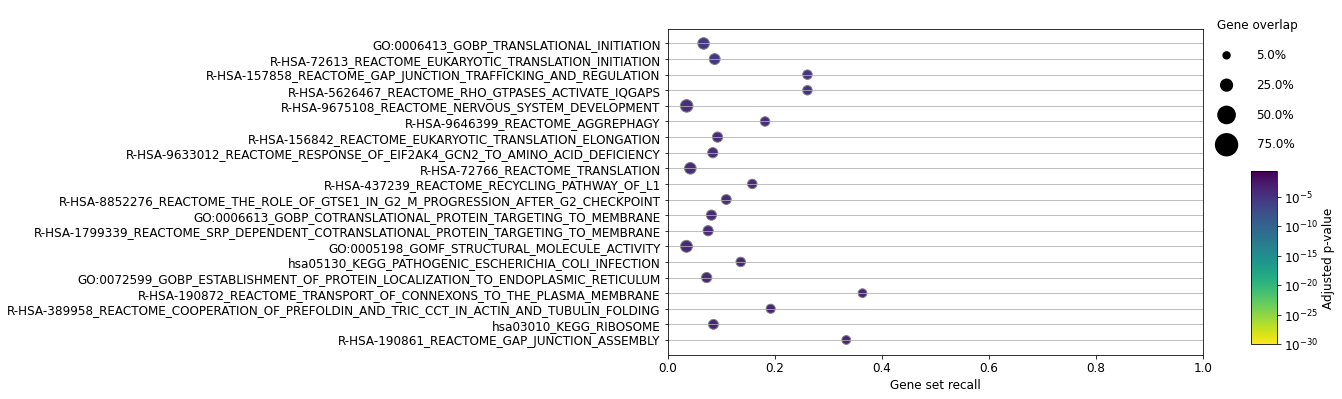

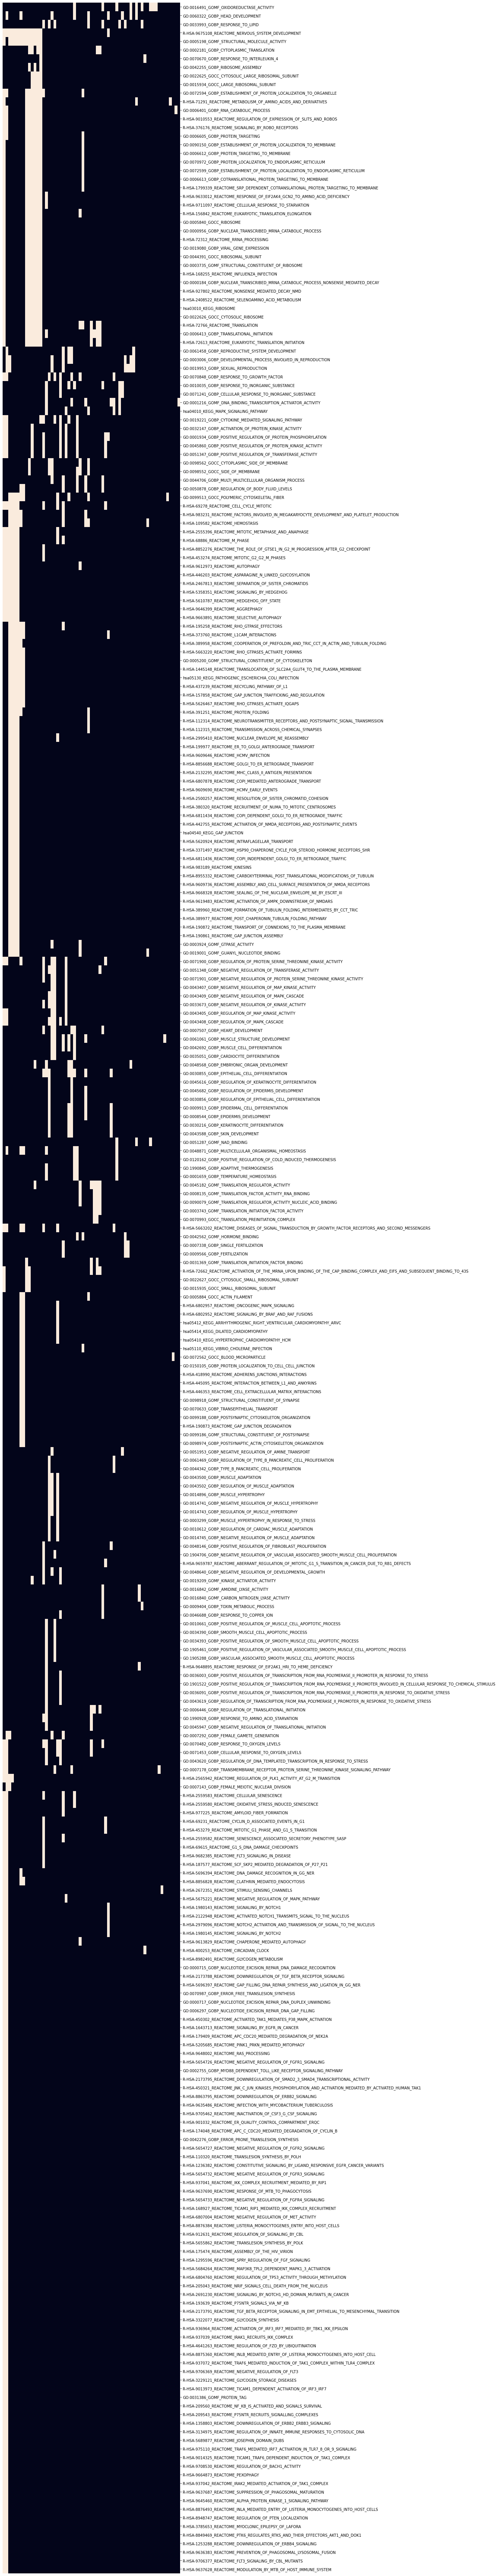

In [25]:
# Perform enrichment per cl
enrich_datas={}
for cl in sorted(adata_genes.obs['hc'].unique()):
    print('CL',cl)    
    # Query genes
    genes=adata_genes.obs.query('hc==@cl').index
    genes=adata_rn_b.var.loc[genes,'gene_symbol'].to_list()
    print('N genes %i'%len(genes))

    # Calculate enrichment
    enrich_fdr=0.25
    ro.globalenv['gs_fdr']=enrich_fdr
    ro.globalenv['genes']=genes
    res=ro.r(f'hypeR(signature=as.vector(unlist(genes)),genesets=gene_sets,test = "hypergeometric",background =  as.vector(unlist(ref)),pval = 1,fdr = gs_fdr,plotting = FALSE,quiet = TRUE)')
    ro.globalenv['res']=res
    data=ro.r(f'res$data')
    enrich_datas[cl]=data
    print('N enriched gene sets:',data.shape[0])

    if data.shape[0]>0:
        # Plot top enriched gene sets
        print('Top enriched gene sets')
        data['recall']=data['overlap']/data['geneset']
        data['query_size']=len(genes)
        h.plot_enrich(data=data.rename(
            {'label':'name','fdr':'p_value','overlap':'intersection_size'},axis=1),
            n_terms=20, save=False,min_pval=10**-30, max_pval=enrich_fdr,percent_size=True,
               recall_lim=(0,1))
        h.plot_enr_heatmap(data=data,n_gs=None,xticklabels=False,yticklabels=True)

# Save enrichment tables
writer = pd.ExcelWriter(path_save+'gene_hc_t'+str(cut_thresh)+'_enrichment.xlsx',
                        engine='xlsxwriter') 
for sheet,data in enrich_datas.items():
    data.to_excel(writer, sheet_name=str(sheet))   
writer.save()

#### Comparison to known beta cell function/marker genes
Correlation of known beta cell function/marker genes and gene scores.

Extract known beta cell markers/functional genes.

In [10]:
# Orthologues
orthologues=pd.read_table(path_genes+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv'
                         ).rename({'Gene name':'gs_mm','Human gene name':'gs_hs'},axis=1)

In [11]:
# Save marker groups
marker_groups=defaultdict(set)

In [12]:
# Functional markers
functional_markers=pd.read_excel(path_genes+'markers.xlsx',sheet_name='beta_function'
                                ).query('cell_type=="type B pancreatic cell"')
# Group markers by main function and map to mouse if necesary
for name,genes in functional_markers.query('organism=="Mus musculus"').groupby('function'
                       )['gene_name'].apply(set).to_dict().items():
    marker_groups['function: '+name].update(genes)
# Group markers by main function and map to mouse if necesary
for name,genes in functional_markers.query('organism=="Homo sapiens"').groupby('function'
                       )['gene_name'].apply(set).to_dict().items():
    genes=orthologues.query('gs_hs in @genes')['gs_mm']
    marker_groups['function: '+name].update(genes)

In [13]:
# Beta subtype markers
subtype_markers=pd.read_excel(path_genes+'markers.xlsx',sheet_name='beta_heterogeneity'
             ).query('cell_type=="type B pancreatic cell"').dropna(subset=['subtype'])
# Group markers by main function and map to mouse if necesary
for name,genes in subtype_markers.query('organism=="Mus musculus"').groupby('subtype'
                       )['gene_name'].apply(set).to_dict().items():
    marker_groups['phenotype: '+name].update(genes)
# Group markers by main function and map to mouse if necesary
for name,genes in subtype_markers.query('organism=="Homo sapiens"').groupby('subtype'
                       )['gene_name'].apply(set).to_dict().items():
    genes=orthologues.query('gs_hs in @genes')['gs_mm']
    marker_groups['phenotype: '+name].update(genes)

Comparison based on mean of per-study mean (across samples) correlation between gene score and marker expression. Plots by known gene groups.
Legend: Red: high corr, blue: low correl.

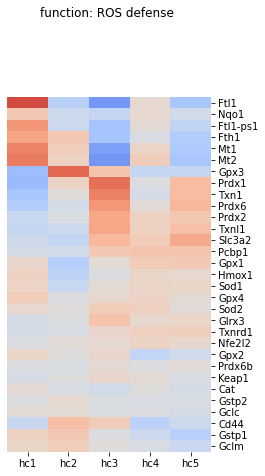

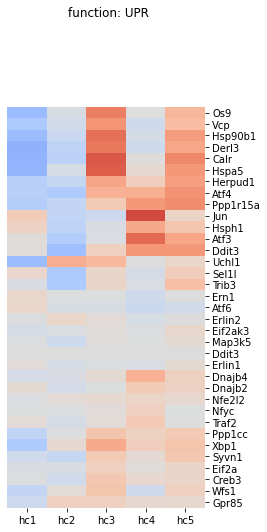

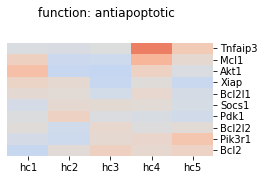

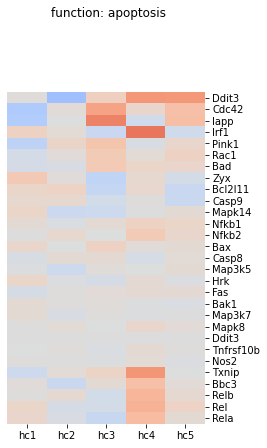

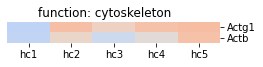

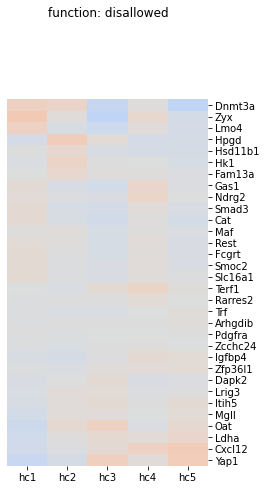

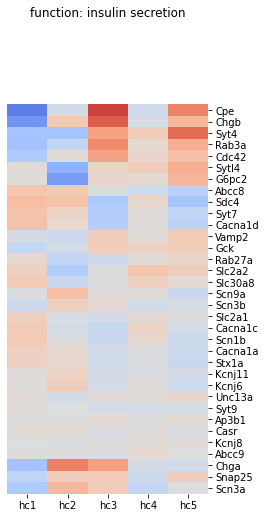

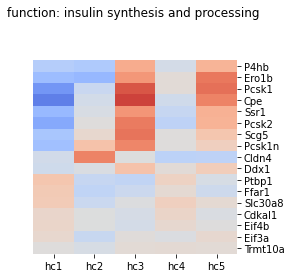

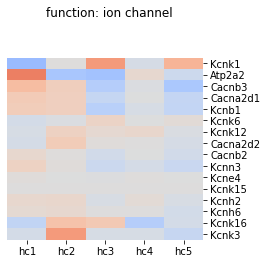

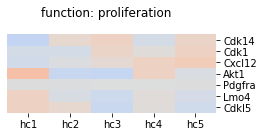

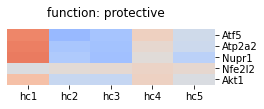

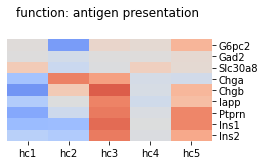

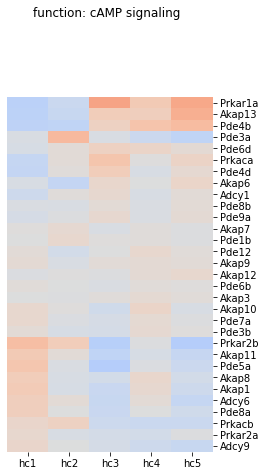

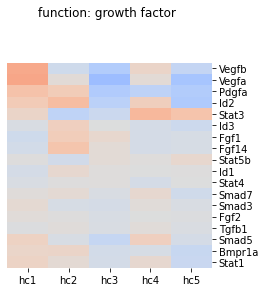

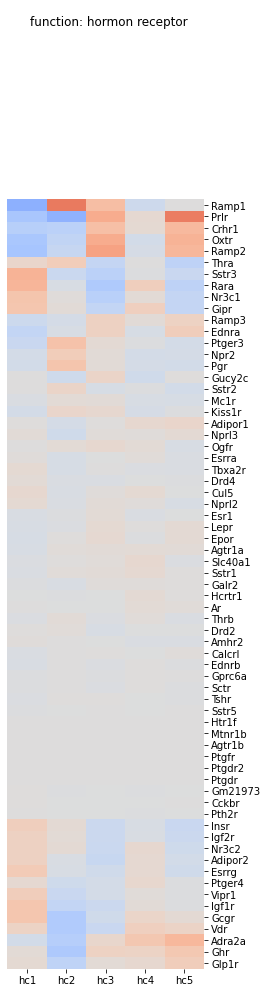

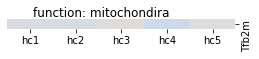

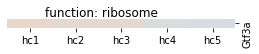

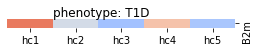

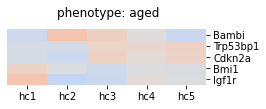

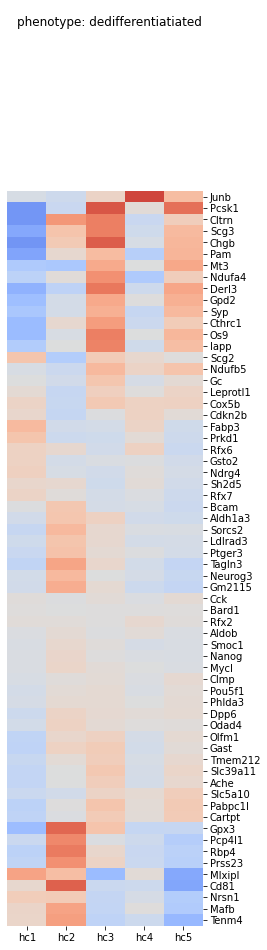

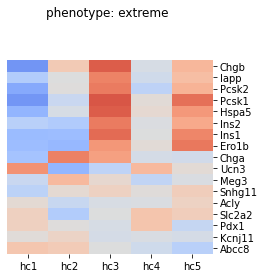

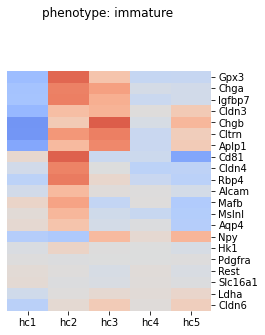

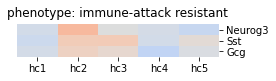

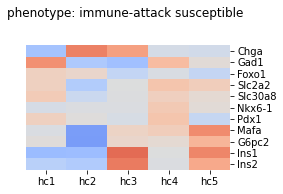

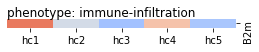

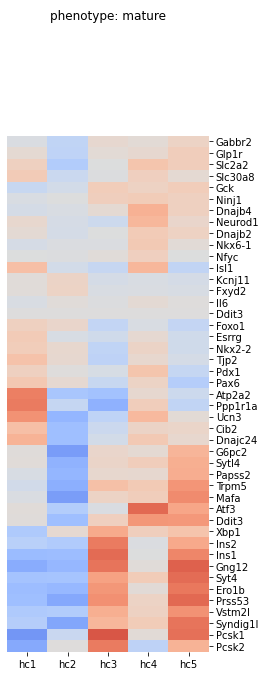

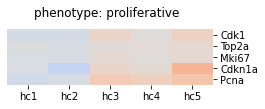

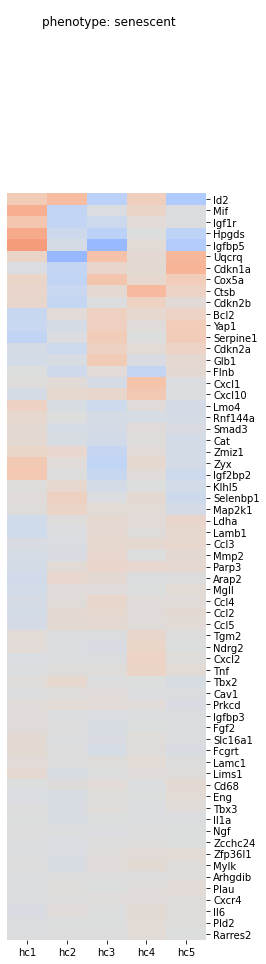

In [215]:
# Compute and plot corr for all known gene groups
for marker_group,markers in marker_groups.items():
    #print(marker_group)
    # Get EIDs from marker gene symbols
    markers_eid={eid:m for m in markers for eid in adata_rn_b.var.query('gene_symbol==@m').index}

    # Similarity between markers and gene groups on per-sample pseudobulk
    similarities_markers={}
    cl_col='leiden_r10'
    # Score columnb names matches across data
    score_cols=['gene_score_cluster_hc'+str(col) for col in sorted(adata_genes.obs['hc'].unique())]
    for sample in samples:
        # Subset to cells from sample
        adata_temp=adata_rn_b[adatas_sub[sample].obs_names,:].copy()
        adata_temp.obs[score_cols+[cl_col]]=adatas_sub[sample].obs[score_cols+[cl_col]]

        # Compute similarities
        data1=adata_temp.obs[score_cols+[cl_col]].groupby(cl_col).mean().T
        data2=adata_temp[:,list(markers_eid.keys())].to_df()
        data2[cl_col]=adata_temp.obs[cl_col]
        data2=data2.groupby(cl_col).mean().T
        sims=[]
        # If data2 should be in rows first go through columns and then rows
        for i in range(data2.shape[0]):
            for j in range(data1.shape[0]):
                sim=np.corrcoef(data1.iloc[j,:],data2.iloc[i,:])[0,1]
                # Set nan in corr to 0 - nan occurs if all gene expression is 0
                sim = sim if not np.isnan(sim) else 0
                sims.append(sim)
        similarities_markers[sample]=np.array(sims)

    del adata_temp
    
    # Compute summarised similarities 
    # Did not use signed min abs across samples as may be problmatic 
    # as 0 may be due to dropout in one sample so loosing info from other samples
    
    # Mean of study means
    # Map to study
    sim_markers=defaultdict(list)
    for sample,sims in similarities_markers.items():
        study=adata_rn_b.obs.query('study_sample_design==@sample').study[0]
        sim_markers[study].append(sims)
    # Mean in study
    sim_markers_temp=[]
    for study, sims in sim_markers.items():
        sim_markers_temp.append(np.array(sims).mean(axis=0))
    # Mean of study means
    sim_markers = np.array(sim_markers_temp).mean(axis=0)
    
    # Convert to similarity matrix
    names1=[col.replace('gene_score_cluster_','') for col in score_cols]
    names2=list(markers_eid.values())
    # Expects data was filled in first by columns (data1) and then by rows (data2)
    sim_markers=pd.DataFrame(sim_markers.reshape(len(names2),len(names1)),
                                 index=names2,columns=names1)


    # Plot similarity heatmap
    if sim_markers.shape[0]>2:
        fg=sb.clustermap(sim_markers,cmap='coolwarm',vmin=-1,vmax=1,yticklabels=True,
                        col_cluster=False,
                         figsize=(4.5,sim_markers.shape[0]*0.2+0.5)
                        )
    else:
        fg=sb.clustermap(sim_markers,cmap='coolwarm',vmin=-1,vmax=1,yticklabels=True,
                        col_cluster=False,row_cluster=False,
                         figsize=(4.5,sim_markers.shape[0]*0.2+0.5)
                        )
    fg.fig.suptitle(marker_group)
    fg.ax_row_dendrogram.set_visible(False)
    fg.cax.set_visible(False)
    display(fg.fig)
    plt.close()

Make a summarised plot with selected known gene groups and genes to be plotted

In [37]:
# Marker groups for plotting
marker_selection={
    'mature':['Ppp1r1a','Ucn3','Cib2','Dnajc24','Papss2',
              'Trpm5','Mafa','Gng12',
              'Prss53','Vstm2l','Syndig1l'],
    'insulin\nrelated':['P4hb','Ero1b','Pcsk1','Cpe','Ssr1','Pcsk2','Scg5','Pcsk1n',
                      'Ddx1','Ffar1','Slc30a8','Chgb','Syt4','Rab3a','Cdc42','Sytl4',
                      'G6pc2','Abcc8','Syt7','Chga','Scn3a','Scn1b','Ins1','Ins2','Iapp'],
    'immature':['Igfbp7','Cldn3','Aplp1','Cldn4',
                'Rbp4','Mafb','Mslnl','Aqp4','Npy','Alcam'],
    'dedifferentiation':['Junb','Cltrn','Scg3','Pam','Mt3','Ndufa4',
                        'Gpd2','Syp','Cthrc1','Ndufb5','Tagln3','Neurog3',
                        'Pcp4l1','Prss23','Cd81','Mlxipl','Tenm4'],
    'UPR':['Os9','Vcp','Hsp90b1','Derl3','Calr','Hspa5','Herpud1','Atf4','Ppp1r15a','Jun',
          'Hsph1','Atf3','Ddit3','Xbp1'],
    'ROS\ndefense':['Ftl1','Nqo1','Ftl1-ps1','Fth1','Mt1','Mt2','Gpx3','Prdx1','Txn1',
                  'Prdx6','Prdx2','Txnl1','Slc3a2','Pcbp1'],
    'hormone\nreceptors':['Gcgr','Insr','Igf1r','Igf2r','Sstr3'],
    'immune\ninfiltration':['B2m','Gad1','Ptprn'],
    '(anti)apoptotic':['Tnfaip3','Mcl1','Bcl2','Bcl2l1','Bcl2l2','Xiap','Casp9',
                      'Bad','Casp8','Txnip','Rel'],
    #'proliferation':['Cdk1','Cdk14','Pdgfra'],
    'protective':['Atf5','Atp2a2','Nupr1','Nfe2l2','Akt1'],
}
marker_selection_map={m:g for g,ms in  marker_selection.items() for m in ms}
# Validation
# All selected markers across groups
marker_sel_all=[m for ms in marker_selection.values() for m in ms]
# Make sure all markers are in adata
print('Markers not in adata:',
      [m for m in set(marker_sel_all) 
      if m not in adata_rn_b.var['gene_symbol'].values])
# Make sure each marker has one EID
print('\nMarkers with multiple eids:\n',
      [adata_rn_b.var.query('gene_symbol==@m') for m in set(marker_sel_all) 
      if adata_rn_b.var.query('gene_symbol==@m').shape[0]>1])
# Make sure marker is in single category
print('\nDuplicated markers:')
counts=pd.Series(marker_sel_all).value_counts()
display(counts[counts>1])

Markers not in adata: []

Markers with multiple eids:
 [                   gene_symbol  used_integration gene_symbol_original_matched
EID                                                                          
ENSMUSG00000025408       Ddit3              True                        Ddit3
ENSMUSG00000116429       Ddit3             False                      Ddit3-1]

Duplicated markers:


Series([], dtype: int64)

C: ENSMUSG00000116429 is unexpressed Ddit3 version.

In [38]:
# Compute similarities with variable gene groups
# Get EIDs from marker gene symbols
markers_eid={eid:m for m in marker_sel_all 
             for eid in adata_rn_b.var.query('gene_symbol==@m').index 
             if eid!='ENSMUSG00000116429'}

# Similarity between markers and gene groups on per-sample pseudobulk
similarities_markers={}
cl_col='leiden_r10'
# Score columnb names matches across data
score_cols=['gene_score_cluster_hc'+str(col) for col in sorted(adata_genes.obs['hc'].unique())]
for sample in samples:
    # Subset to cells from sample
    adata_temp=adata_rn_b[adatas_sub[sample].obs_names,:].copy()
    adata_temp.obs[score_cols+[cl_col]]=adatas_sub[sample].obs[score_cols+[cl_col]]

    # Compute similarities
    data1=adata_temp.obs[score_cols+[cl_col]].groupby(cl_col).mean().T
    data2=adata_temp[:,list(markers_eid.keys())].to_df()
    data2[cl_col]=adata_temp.obs[cl_col]
    data2=data2.groupby(cl_col).mean().T
    sims=[]
    # If data2 should be in rows first go through columns and then rows
    for i in range(data2.shape[0]):
        for j in range(data1.shape[0]):
            sim=np.corrcoef(data1.iloc[j,:],data2.iloc[i,:])[0,1]
            # Set nan in corr to 0 - nan occurs if all gene expression is 0
            sim = sim if not np.isnan(sim) else 0
            sims.append(sim)
    similarities_markers[sample]=np.array(sims)

del adata_temp

# Compute summarised similarities 

# Mean of study means
# Map to study
sim_markers=defaultdict(list)
for sample,sims in similarities_markers.items():
    study=adata_rn_b.obs.query('study_sample_design==@sample').study[0]
    sim_markers[study].append(sims)
# Mean in study
sim_markers_temp=[]
for study, sims in sim_markers.items():
    sim_markers_temp.append(np.array(sims).mean(axis=0))
# Mean of study means
sim_markers = np.array(sim_markers_temp).mean(axis=0)

# Convert to similarity matrix
names1=[col.replace('gene_score_cluster_','') for col in score_cols]
names2=list(markers_eid.values())
# Expects data was filled in first by columns (data1) and then by rows (data2)
sim_markers=pd.DataFrame(sim_markers.reshape(len(names2),len(names1)),
                             index=names2,columns=names1)

# Rename groups
sim_markers.columns=sim_markers.columns.str.replace('hc','')

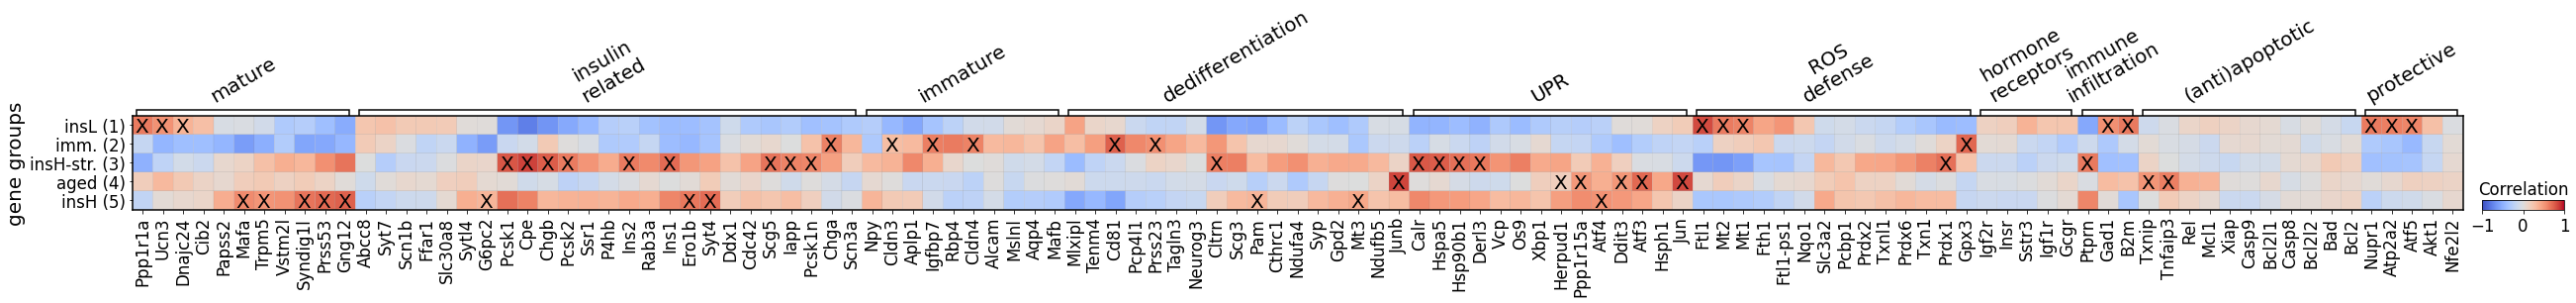

In [51]:
# Plot correlations 
# Order marker groups and markers
var_names={}
for group,markers in marker_selection.items():
    var_names[group]=np.array(markers)[h.opt_order(
        X=sim_markers.loc[markers,:],
        metric='euclidean',method='ward')]
# Reset fontsize for plotting
fs=rcParams['font.size']
rcParams.update({'font.size': 20})
cl_names_map={'1':'insL (1)','2':'imm. (2)', '3':'insH-str. (3)','4':'aged (4)','5':'insH (5)'}
cl_names=pd.DataFrame({'cl':sim_markers.columns.to_list()},
                            index=sim_markers.T.index).replace(cl_names_map)
cl_names['cl']=pd.Categorical(values=cl_names.cl,ordered=True,categories=cl_names_map.values())
mp=sc.pl.matrixplot(sc.AnnData(sim_markers.T, obs=cl_names), var_names=var_names, 
                 groupby='cl', dendrogram=False,
                colorbar_title='Correlation', cmap ='coolwarm',var_group_rotation=30,
                vmin=-1,vmax=1,return_fig=True,show=False)
# Make figure from matrixplot - neccessary for saving
mp.make_figure()
mp.get_axes()['mainplot_ax'].set_ylabel('gene groups')
# Add annotation of gene being in GP
# Gene sorting order is based on given var names not plotted df index
for idx_c,gene in enumerate([g for gs in var_names.values() for g in gs]):
    for idx_r,gcl in enumerate(sim_markers.columns):
        gcl=int(gcl)
        cl_genes=set(genes_hc_data.query('hc==@gcl').gene_symbol)
        if gene in cl_genes:
            mp.get_axes()['mainplot_ax'].text(idx_c + 0.45, idx_r + 0.55, 'X',
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.savefig(path_fig+'heatmap_beta_healthyVar_markersCorr.png',dpi=300,bbox_inches='tight')
rcParams.update({'font.size': fs})

### Exprerssion across all beta cells

Score all beta cells (not just healthy)

In [18]:
# gene cluster scores
gene_cl='hc'
adata_rn_b.obs.drop([col for col in adata_rn_b.obs.columns 
                     if 'gene_score_cluster_'+gene_cl in col],axis=1,inplace=True)
for ct in sorted(adata_genes.obs[gene_cl].unique()):
    score_name='gene_score_cluster_'+gene_cl+str(ct)
    sc.tl.score_genes(adata_rn_b, 
                      gene_list=adata_genes.obs_names[adata_genes.obs[gene_cl]==ct], 
                     score_name=score_name, use_raw=False)
    # Scale over cells
    adata_rn_b.obs[score_name+'_scaled']=minmax_scale(adata_rn_b.obs[score_name])

Activity on UMAP

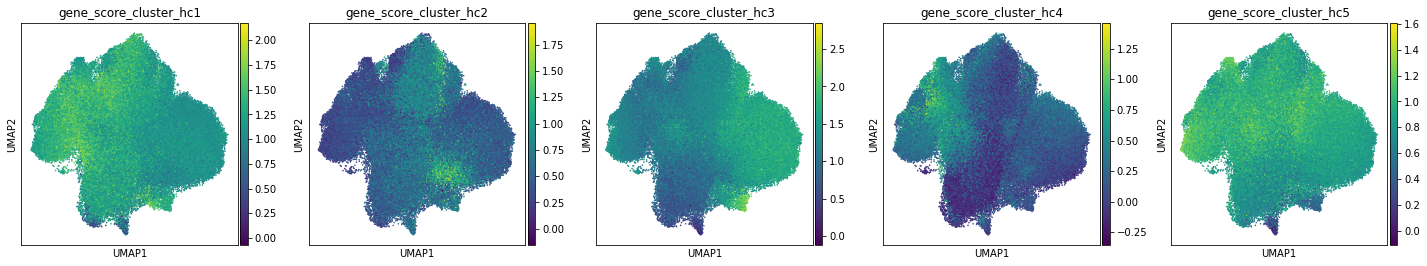

In [29]:
rcParams['figure.figsize']=(4,4)
random_indices=np.random.permutation(list(range(adata_rn_b.shape[0])))
sc.pl.umap(adata_rn_b[random_indices,:],color=[col for col in adata_rn_b.obs.columns 
    if 'gene_score_cluster_hc' in col and '_scaled'  not in col], s=10,sort_order=False,ncols=5)

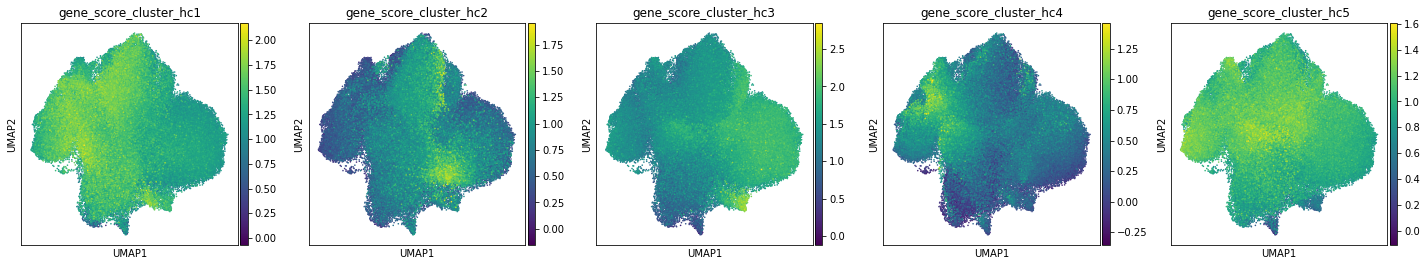

In [30]:
rcParams['figure.figsize']=(4,4)
sc.pl.umap(adata_rn_b,color=[col for col in adata_rn_b.obs.columns 
    if 'gene_score_cluster_hc' in col and '_scaled' not  in col], s=10,ncols=5)

Activity on coarse clusters

In [11]:
adata_rn_b

AnnData object with n_obs × n_vars = 102143 × 30672
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'pre_cell_type', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'strain', 'tissue', 'technique', 'internal_id', 'batch', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'design', 'cell_type_integrated', 'cell_type_integrated_v1', 'gcg_score_scaled', 'ins_score_scaled', 'ppy_score_scaled', 'sst_score_scaled', 'n_counts', 'n_genes', 'mt_frac', 'emptyDrops_LogProb', 'emptyDrops_LogProb_scaled', 'leiden_r0.4', 'leiden_r0.7', 'leiden_r1', 'leiden_r1.5', 'leiden_r2', 'size_factors_integrated', 'de_aging_dpt_pseudotime', 'de_diseased_healthy_diseased_axis', 'de_diseased_healthy_diseased_cl_axis', 'de_diseased_healthy_diseased_cl_axis_sub',

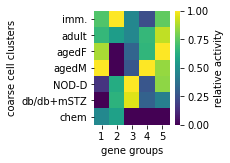

In [30]:
# Make pseudobulk
# Mean within beta clusters of gene programs
# Unscaled across cell clusters, but rather across cells as less cell clusters here
# Rescale on subsetted (no low quality)
x=adata_rn_b.obs[
    ~adata_rn_b.obs['leiden_r1.5_parsed'].str.startswith('lowQ')
    ][[col for col in adata_rn_b.obs.columns
        if 'gene_score_cluster_hc' in col and '_scaled' not in col]]
#x=pd.DataFrame(scale(x),  index=x.index,  columns=x.columns)
x['cl']=adata_rn_b.obs.loc[x.index,'leiden_r1.5_parsed']
pseudobulk_gp_scaled=x.groupby('cl', observed=True).mean()
pseudobulk_gp_scaled=pd.DataFrame(minmax_scale(pseudobulk_gp_scaled),  
                                  index=pseudobulk_gp_scaled.index, 
                                  columns=pseudobulk_gp_scaled.columns)
del x
pseudobulk_gp_scaled.index.name='coarse cell clusters'

# Order cell clusters
#pseudobulk_gp_scaled=pseudobulk_gp_scaled.loc[
#    pseudobulk_gp_scaled.index[h.opt_order(pseudobulk_gp_scaled,metric='correlation',
#                                           method='ward')],:]
# Order gene groups
#pseudobulk_gp_scaled=pseudobulk_gp_scaled.loc[:,
#    pseudobulk_gp_scaled.columns[h.opt_order(pseudobulk_gp_scaled.T,metric='correlation',
#                                           method='ward')]]

# rename columns to be shorter
pseudobulk_gp_scaled.columns=[col.replace('gene_score_cluster_hc','').replace('_scaled','')
                           for col in pseudobulk_gp_scaled.columns]
pseudobulk_gp_scaled.columns.name='gene groups'

# Plot
fig,ax=plt.subplots(figsize=(pseudobulk_gp_scaled.shape[1]*0.3+0.2,
                             pseudobulk_gp_scaled.shape[0]*0.3))
g=sb.heatmap(pseudobulk_gp_scaled,
             cbar_kws={'label': 'relative activity'},cmap='viridis')
plt.savefig(path_fig+'heatmap_beta_healthyvaractivity_CLcoarse.png',dpi=300,bbox_inches='tight')

Expression of individual genes from clusters across beta cell fine clusters

In [105]:
# Mean expression over beta cell clusters, normnalized to [0,1] for each gene
data_genes_pb=adata_rn_b.to_df()
data_genes_pb=pd.concat([data_genes_pb,
                         adata_rn_b.obs['hc_gene_programs'].rename('cell_cluster')],axis=1)
data_genes_pb=data_genes_pb.groupby('cell_cluster').mean().T
data_genes_pb=pd.DataFrame(minmax_scale(data_genes_pb,axis=1),
                       index=data_genes_pb.index,columns=data_genes_pb.columns)

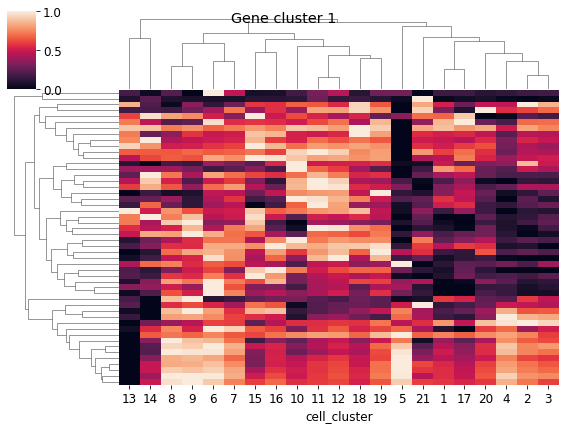

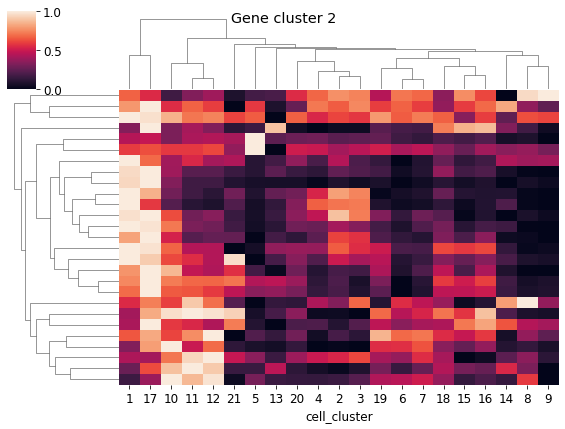

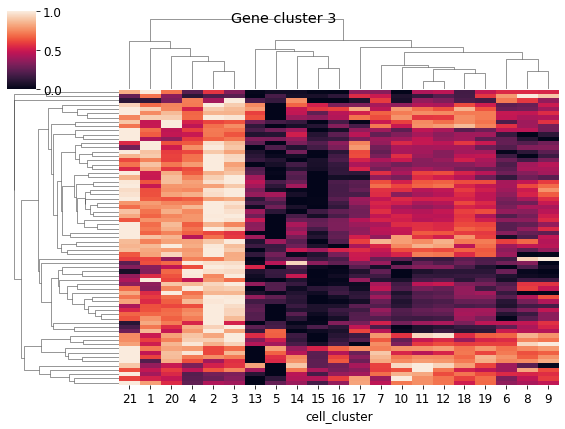

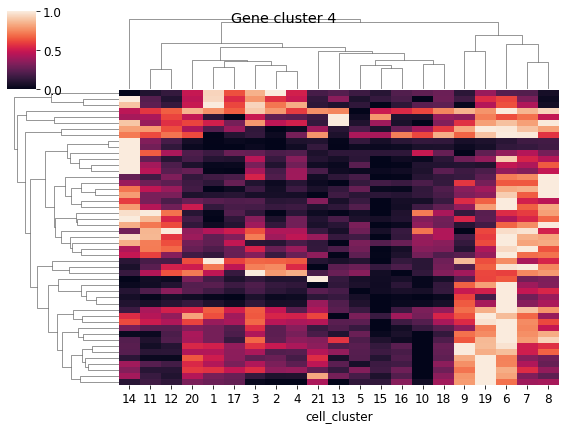

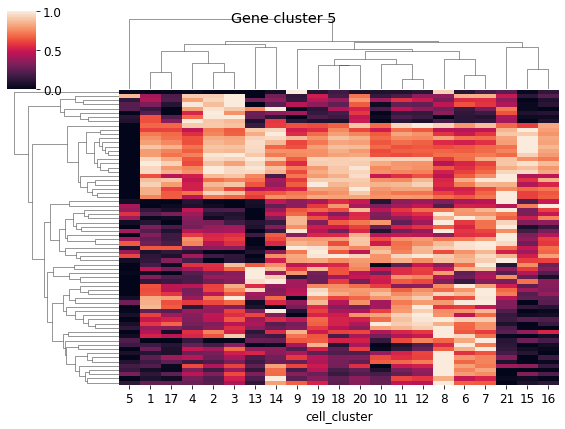

In [117]:
for cl in sorted(adata_genes.obs['hc'].unique()):
    g=sb.clustermap(data_genes_pb.loc[adata_genes.obs.query('hc==@cl').index.to_list(),:],
                  yticklabels=False,xticklabels=True,figsize=(8,6))
    g.fig.suptitle('Gene cluster '+str(cl))

C: here not all genes look corelated within clusters, which is expected as gene similarity is determined based on healthy samples only.

### Compare gene clusters

Compute similarity between cluster scores per sample and keep signed min abs correlation similarity across samples as the selected similarity.

In [11]:
# Similarity between genes within samples on per-sample pseudobulk
similarities={}
cl_col='leiden_r10'
# Score columnb names matches across data
score_cols=['gene_score_cluster_hc'+str(col) for col in sorted(adata_genes.obs['hc'].unique())]
for sample in samples:
    print(sample)
    # Subset to cells from sample
    adata_temp=adatas_sub[sample].copy()
    
    # Compute similarities
    data=adata_temp.obs[score_cols+[cl_col]].groupby(cl_col).mean().T
    dist=pdist(data,metric='correlation')
    # Convert to similarity from correlation metric
    sim=1-dist
    similarities[sample]=sim
    
del adata_temp

STZ_G1_control
VSG_MUC13633_chow_WT
VSG_MUC13634_chow_WT
Fltp_adult_mouse1_head_Fltp-
Fltp_adult_mouse2_head_Fltp+
Fltp_adult_mouse4_tail_Fltp+
Fltp_adult_mouse3_tail_Fltp-


In [31]:
# Compute summarised similarities as signed min abs across samples
sim_min=np.array([sim for sim in similarities.values()])
sim_min=sim_min[(np.argmin(abs(sim_min),axis=0),list(range(sim_min.shape[1])))]
# Convert to similarity matrix
names=[col.replace('gene_score_cluster_','') for col in score_cols]
sim_min=pd.DataFrame(squareform(sim_min),index=names,columns=names)
# Add 1 on diagonal
sim_min.values[tuple([np.arange(sim_min.shape[0])])*2] = 1

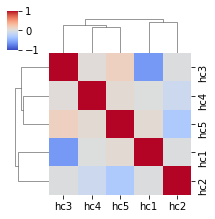

In [32]:
sb.clustermap(sim_min,cmap='coolwarm',vmin=-1,vmax=1,figsize=(3,3))

Detailed comparison of pairwise score distributions as 2D kde plots for each study

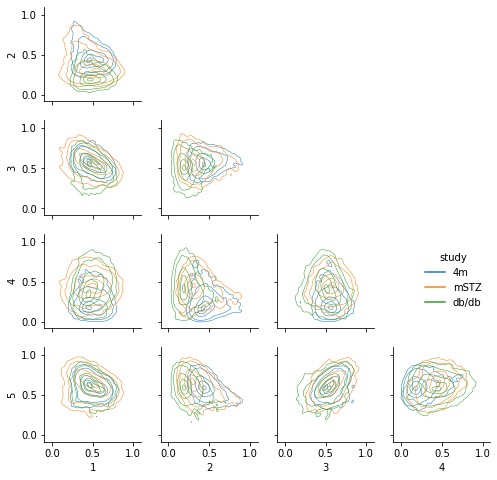

In [36]:
# Make 2d KDEs for all combinations in a grid
# Make grid of size-1 to omit self-self idxs
score_cols=['gene_score_cluster_hc'+str(col)+'_scaled' 
            for col in sorted(adata_genes.obs['hc'].unique())]
n_cols=len(score_cols)
n_img_cols=n_cols-1
fig,axs=plt.subplots(n_img_cols,n_img_cols,figsize=(2*n_img_cols,2*n_img_cols),
                    sharey=True,sharex=True)
# Go ower cols and rows
for idx_col in range(n_img_cols):
    # Plot on bottom tirange
    # Remove axs thwat would stay empty
    for idx_row in range(0,n_img_cols):
        if idx_row<idx_col:
            axs[idx_row,idx_col].remove()
        else:    
            ax=axs[idx_row,idx_col]
            # Get column indices
            i=idx_col
            j=idx_row+1
            g=sb.kdeplot(x=score_cols[i], y=score_cols[j], hue='study_parsed',
                 data=adata_rn_b_sub_h.obs, linewidths=0.5,
                         levels=[0.01,0.05,0.33,0.66,0.95], common_norm=False, ax=ax)
            # Quicker function for testing
            #g=sb.scatterplot(x=score_cols[i],y=score_cols[j],hue='study_parsed',
            #     data=adata_rn_b_sub_h.obs, 
            #             ax=ax)
            
            # Edit ax - frameoff partially
            ax.set(facecolor = (0,0,0,0))
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # Set labels of ax on edges
            if idx_col==0:
                ax.set_ylabel(
                    score_cols[j].replace('gene_score_cluster_hc','').replace('_scaled',''))
            if idx_row==(n_img_cols-1):
                ax.set_xlabel(
                    score_cols[i].replace('gene_score_cluster_hc','').replace('_scaled',''))
            # Make legend only 1x and make it transparent
            if idx_col==0 and idx_row==0:
                g.legend_.set_bbox_to_anchor((4.6, -1.5))
                g.legend_.get_frame().set_alpha(None)
                g.legend_.get_frame().set_facecolor((0, 0, 0, 0))
                g.legend_.get_frame().set_edgecolor((0, 0, 0, 0))
                g.legend_.set_title('study')
            else:
                g.legend_.remove()
plt.savefig(path_fig+'kde_beta_healthyvar_sample.png',dpi=300,bbox_inches='tight')

C: Some observed patterns:
- 3 & 5 are correlated, while 1 & 3 and 1 & 5 are anticorrelated.
- High scores for 1 & 2, 2 & 4, and 2 & 5 seem mutually exclusive.

## Save

In [28]:
# Add symbols and save
genes_hc_data=adata_genes.obs['hc'].to_frame()
genes_hc_data['gene_symbol']=adata_rn_b_sub.var.loc[genes_hc_data.index,'gene_symbol']
genes_hc_data['rel_beta_expr']=genes_info.loc[
    genes_hc_data.index,'rel_maxscl_beta_expr_cl'].values
genes_hc_data[['mean_expr_in_expr_cells','N_PMID','N_PMID_pancreas_notCancerNonendo']]=\
    genes_info.loc[genes_hc_data.index,
                   ['mean_expr_in_expr_cells','N_PMID','N_PMID_pancreas_notCancerNonendo']]
genes_hc_data.to_csv(path_save+'gene_hc_t'+str(cut_thresh)+'.tsv',sep='\t')

In [29]:
genes_hc_data

hc gene_symbol  rel_beta_expr  mean_expr_in_expr_cells  \
ENSMUSG00000073530   3      Pappa2       0.649646                 1.198574   
ENSMUSG00000036856   2        Wnt4       1.000000                 1.376984   
ENSMUSG00000053560   4        Ier2       0.546635                 1.050378   
ENSMUSG00000044988   1        Ucn3       1.000000                 1.515771   
ENSMUSG00000028757   3       Ddost       1.000000                 1.624765   
...                 ..         ...            ...                      ...   
ENSMUSG00000064351   1      mt-Co1       1.000000                 4.754871   
ENSMUSG00000029780   3       Nt5c3       1.000000                 0.965134   
ENSMUSG00000073411   3       H2-D1       0.603752                 1.738229   
ENSMUSG00000018339   2        Gpx3       0.562181                 1.332709   
ENSMUSG00000060802   1         B2m       0.463461                 1.116816   

                    N_PMID  N_PMID_pancreas_notCancerNonendo  
ENSMUSG00000073530    47.0                               0.0  
ENSMUSG00000036856   111.0                               0.0  
ENSMUSG00000053560    17.0                               0.0  
ENSMUSG00000044988    34.0                               3.0  
ENSMUSG00000028757   117.0                               6.0  
...                    ...                               ...  
ENSMUSG00000064351    78.0                               6.0  
ENSMUSG00000029780    52.0                               0.0  
ENSMUSG00000073411     0.0                               0.0  
ENSMUSG00000018339   112.0                               6.0  
ENSMUSG00000060802   416.0                              13.0  

[265 rows x 6 columns]